In [11]:
import os
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch.autograd import Variable
from torchvision.utils import save_image
import torch.nn.functional as F
from PIL import Image
import pandas as pd
import cv2
# import matplotlib as plt
from matplotlib import pyplot as plt



class customDataset(Dataset):
    def __init__(self, annotations, img_dir, flag="train", transform=None, target_transform=None):
        # super().__init__()
        assert flag in ["train", "test"]
        self.flag = flag

        self.image_labels = pd.read_csv(annotations)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_labels)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.image_labels.iloc[index, 0])
        # print(img_path)
        image = Image.fromarray(cv2.imread(img_path, -1), mode="L")
        label = self.image_labels.iloc[index, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, int(label)


class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1,64,3,1,1),
            torch.nn.ReLU(),  #activation function
            torch.nn.Conv2d(64,128,3,1,1),
            torch.nn.ReLU(),  #activation function
            torch.nn.MaxPool2d(2,2)
        )
        self.dense = torch.nn.Sequential(
            torch.nn.Linear(14*14*128, 1024),
            torch.nn.ReLU(),  #activation function
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(1024,10)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 14*14*128)
        x = self.dense(x)
        # x = F.softmax(x, dim=1)
        # top_probs, top_labels = torch.topk(x, k=10)
        # print(top_probs)
        # print(top_labels)
        return x
    



def activation_data(model, input, output):
    print("+++++++++++++++++++++++++++++++")

    A = output[0].cpu().detach().numpy()

    plt.title("The activation")
    plt.xlabel("index")
    plt.ylabel("value")
    X, = plt.plot(A)
    plt.legend([X], ["Activation"])
    plt.rcParams["figure.figsize"] = (20, 10)
    plt.show()
    


1
+++++++++++++++++++++++++++++++


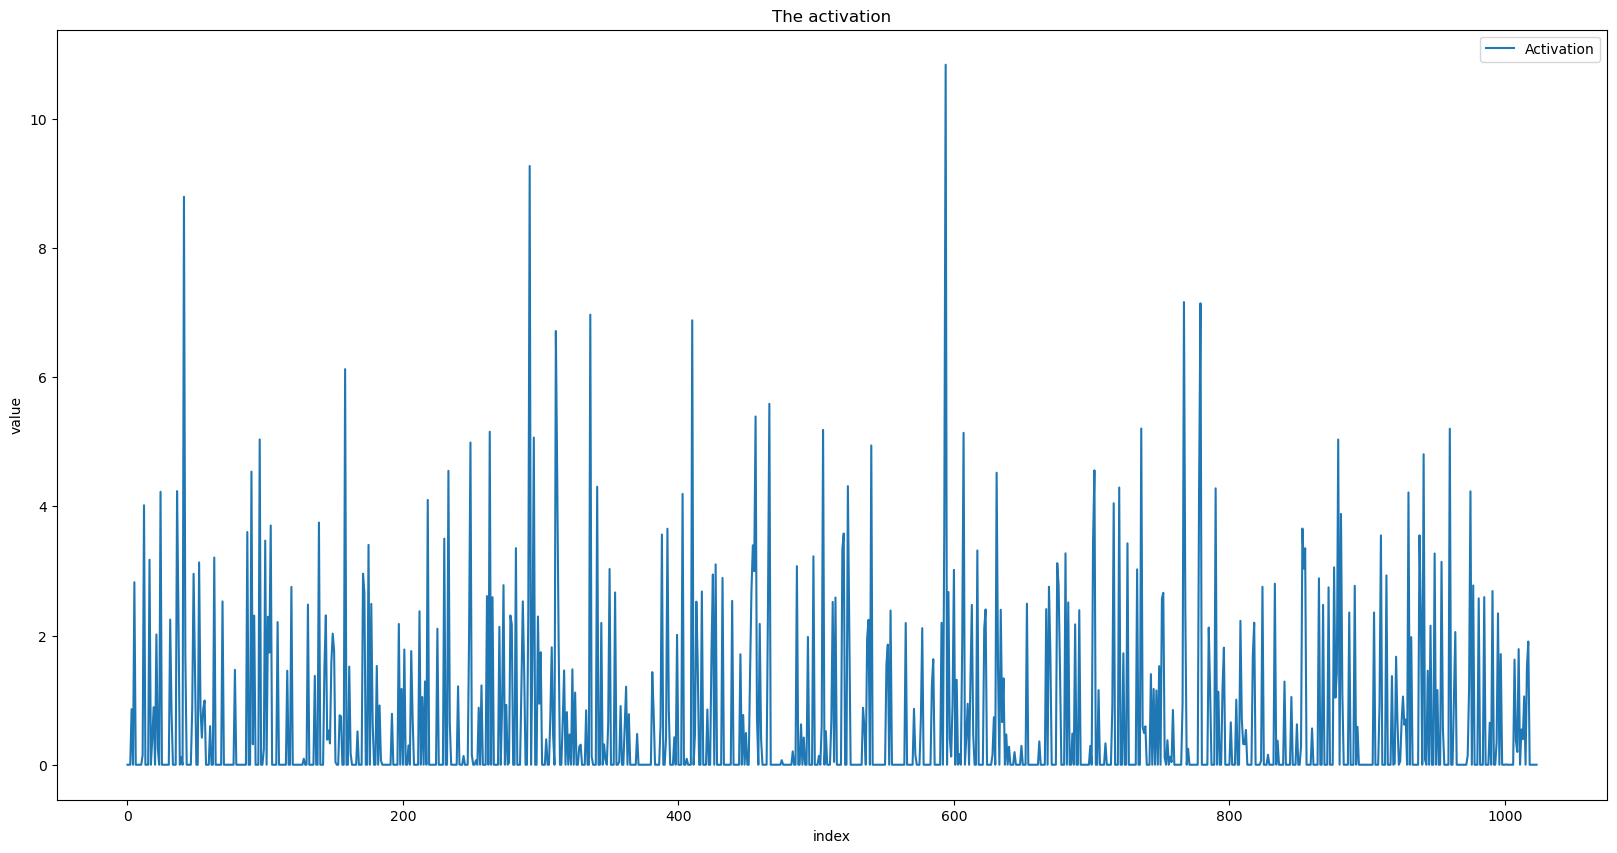

2
+++++++++++++++++++++++++++++++


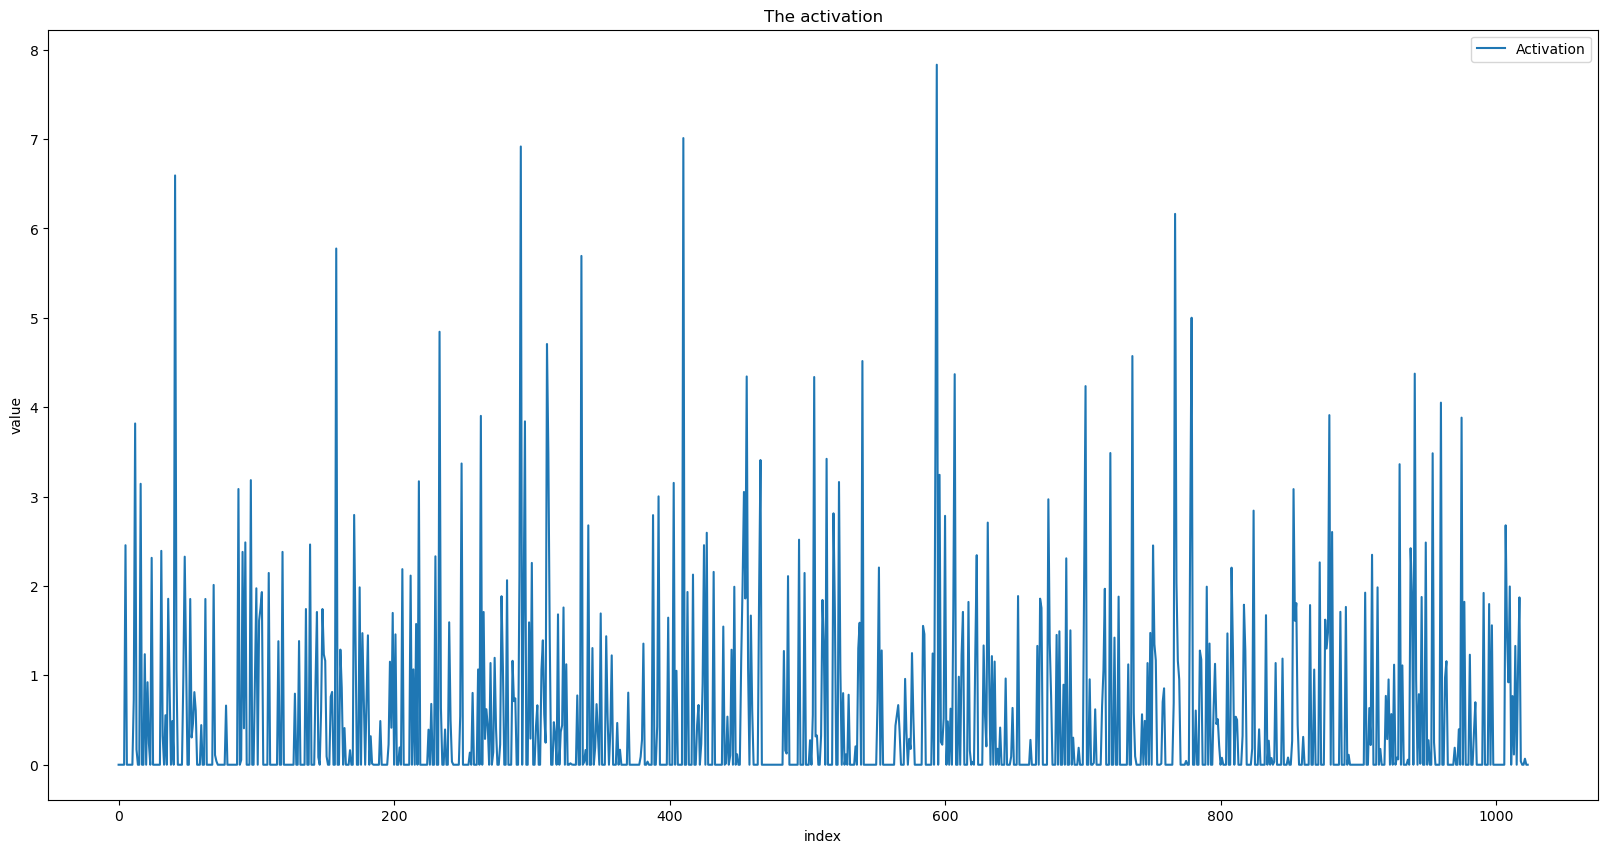

3
+++++++++++++++++++++++++++++++


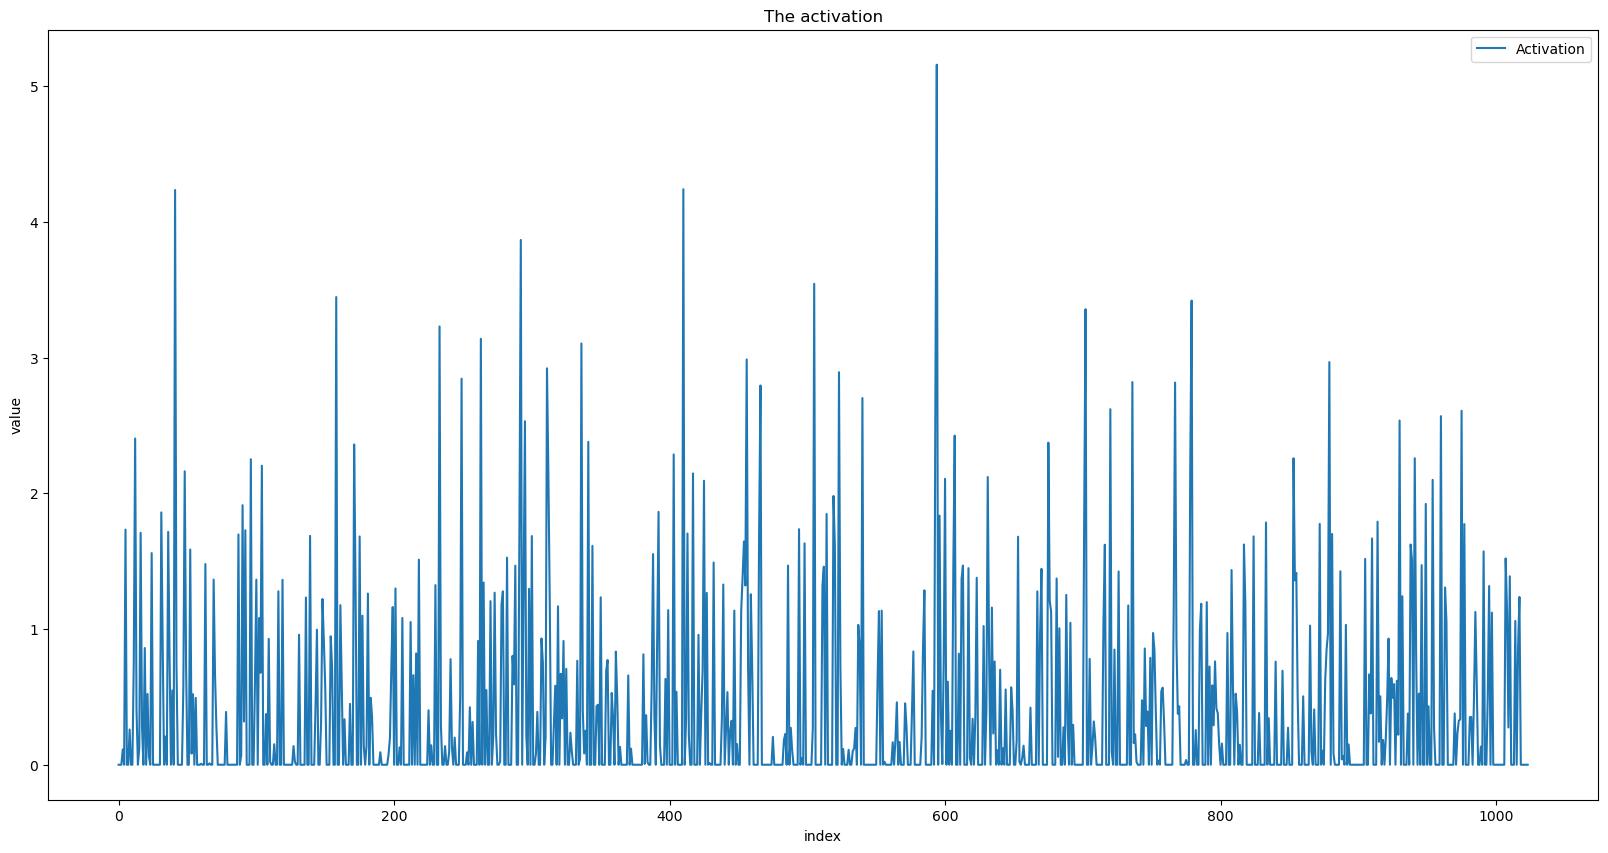

4
+++++++++++++++++++++++++++++++


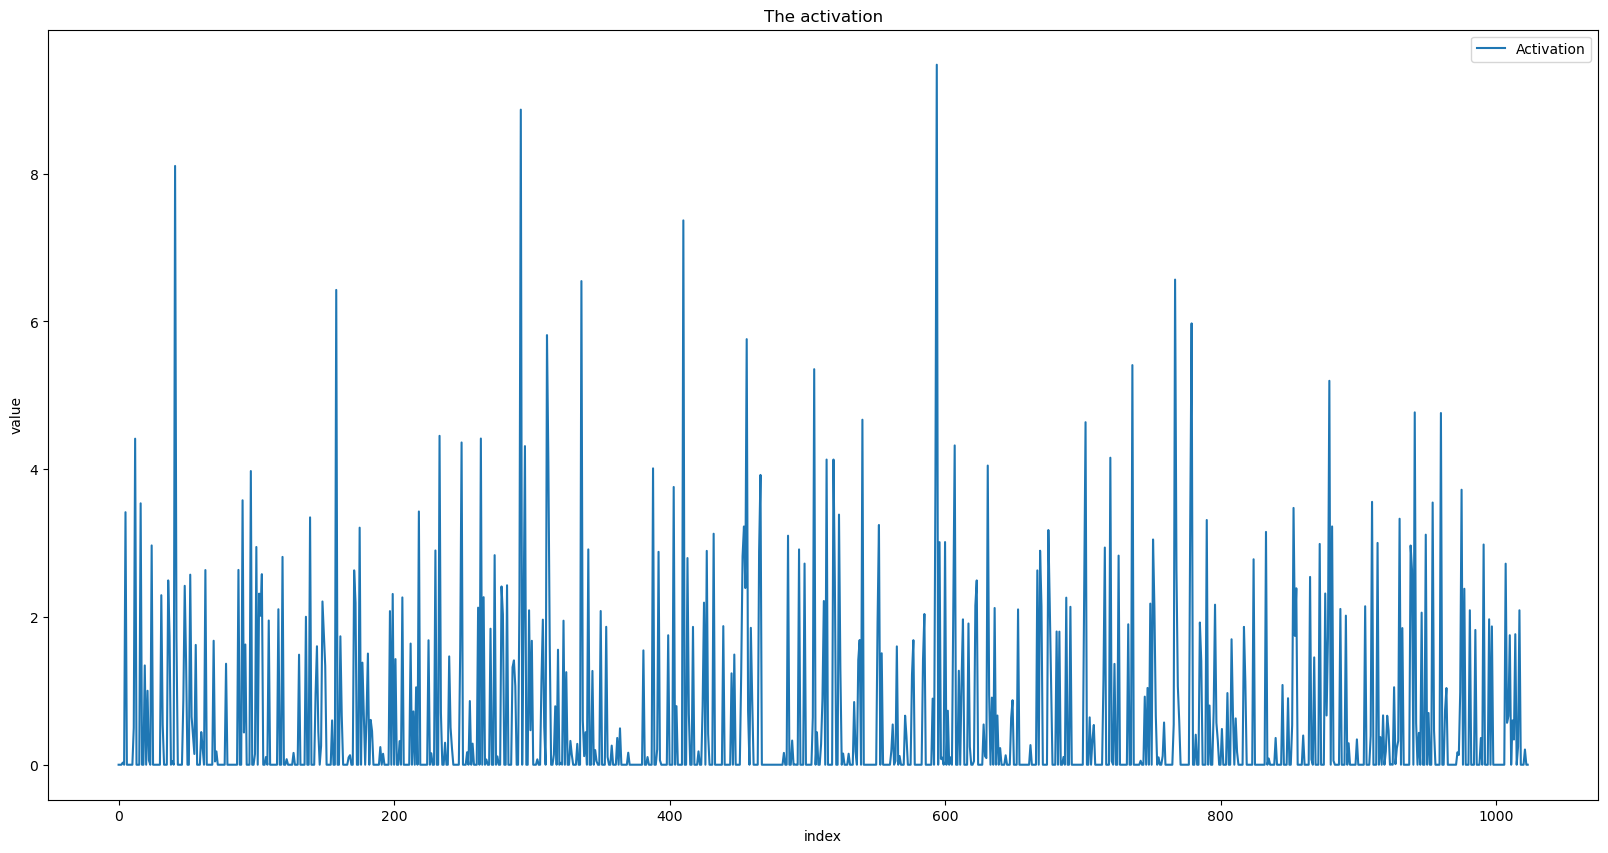

5
+++++++++++++++++++++++++++++++


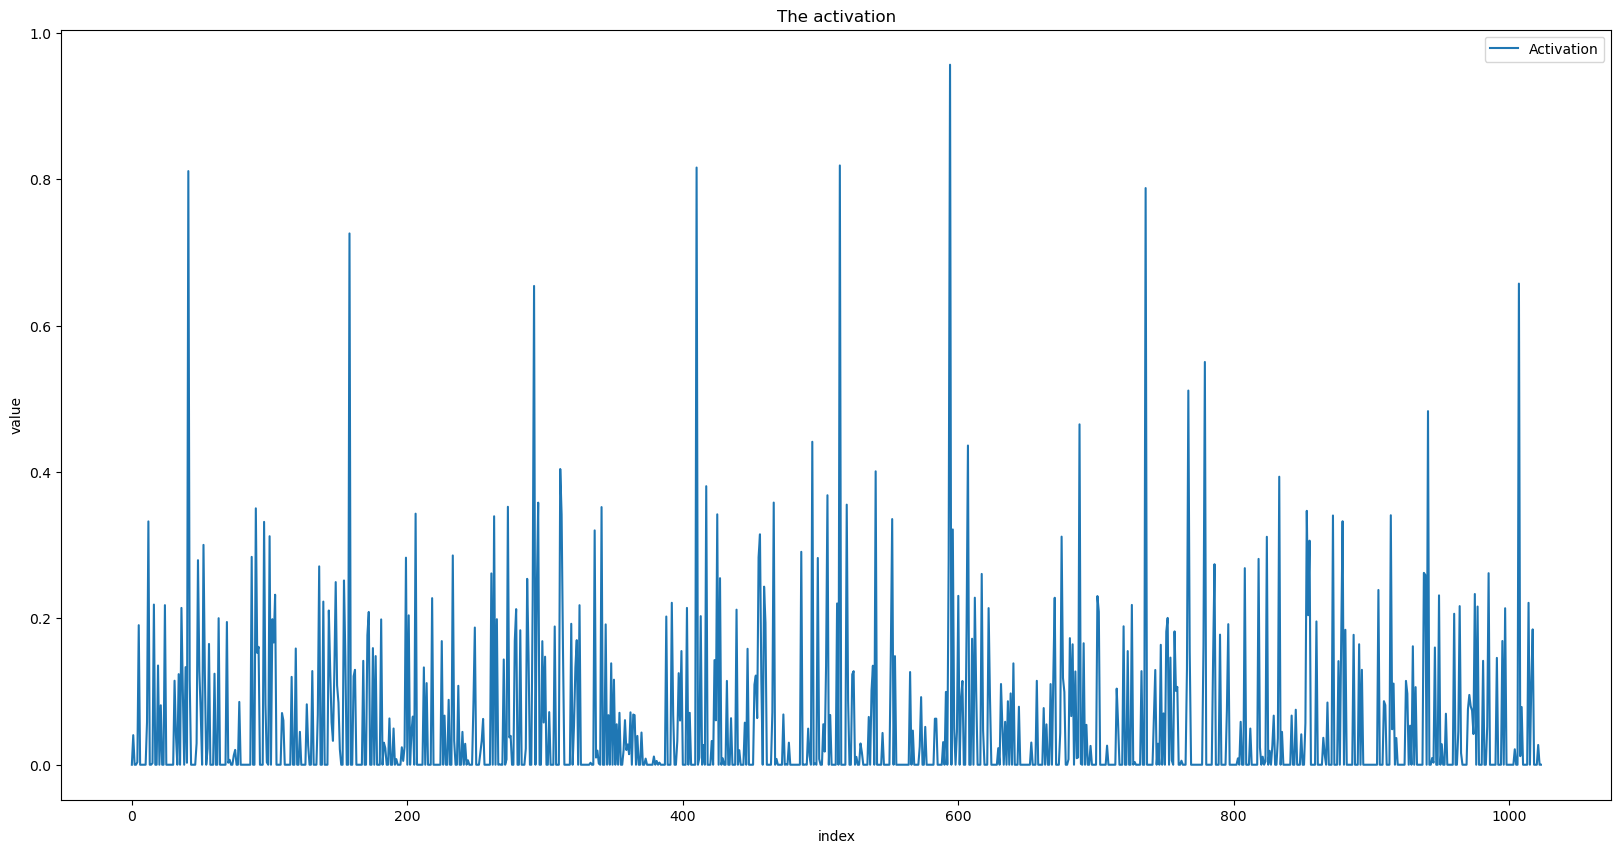

In [12]:
device = (
"cuda"
if torch.cuda.is_available()
else "cpu")

testData= customDataset(annotations="data/testPoisonedMNIST/label.csv", img_dir="data/testPoisonedMNIST/img", transform=transforms.ToTensor(), flag="train")
dataloader = DataLoader(dataset=testData, batch_size=1, shuffle=True)

target_model = NeuralNetwork().to(device)
target_model.load_state_dict(torch.load("./model/MNIST_poisoned.pth"))
torch.no_grad()
target_model.eval()

handle = target_model.dense[1].register_forward_hook(activation_data)
x = 0

for i, y in dataloader:
    x += 1
    print(x)
    i = i.to(device)
    output = target_model(i)
handle.remove()

1
+++++++++++++++++++++++++++++++


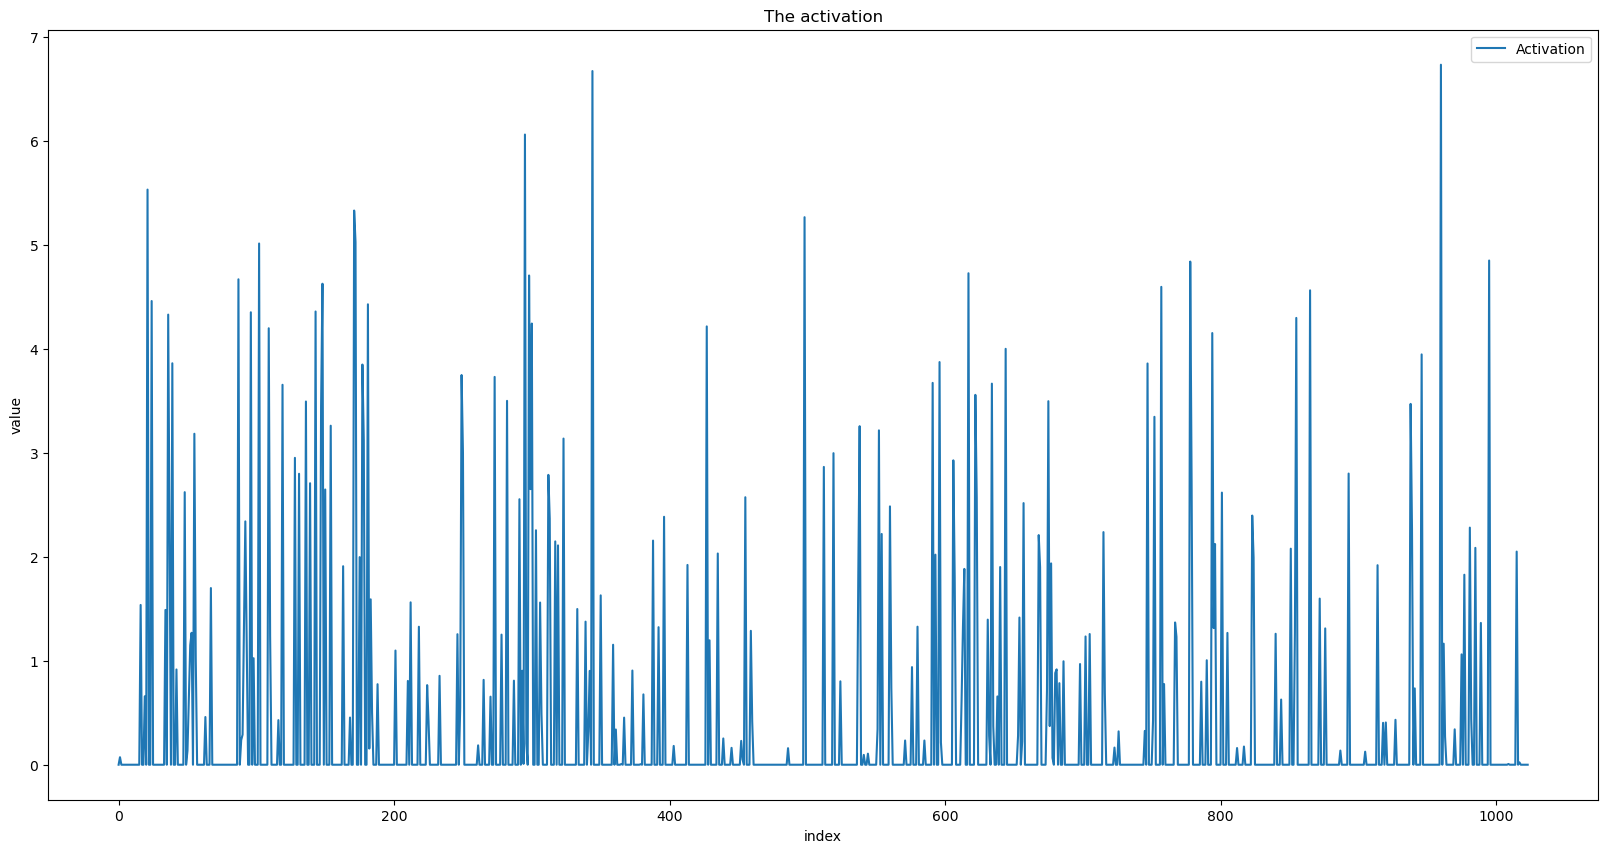

2
+++++++++++++++++++++++++++++++


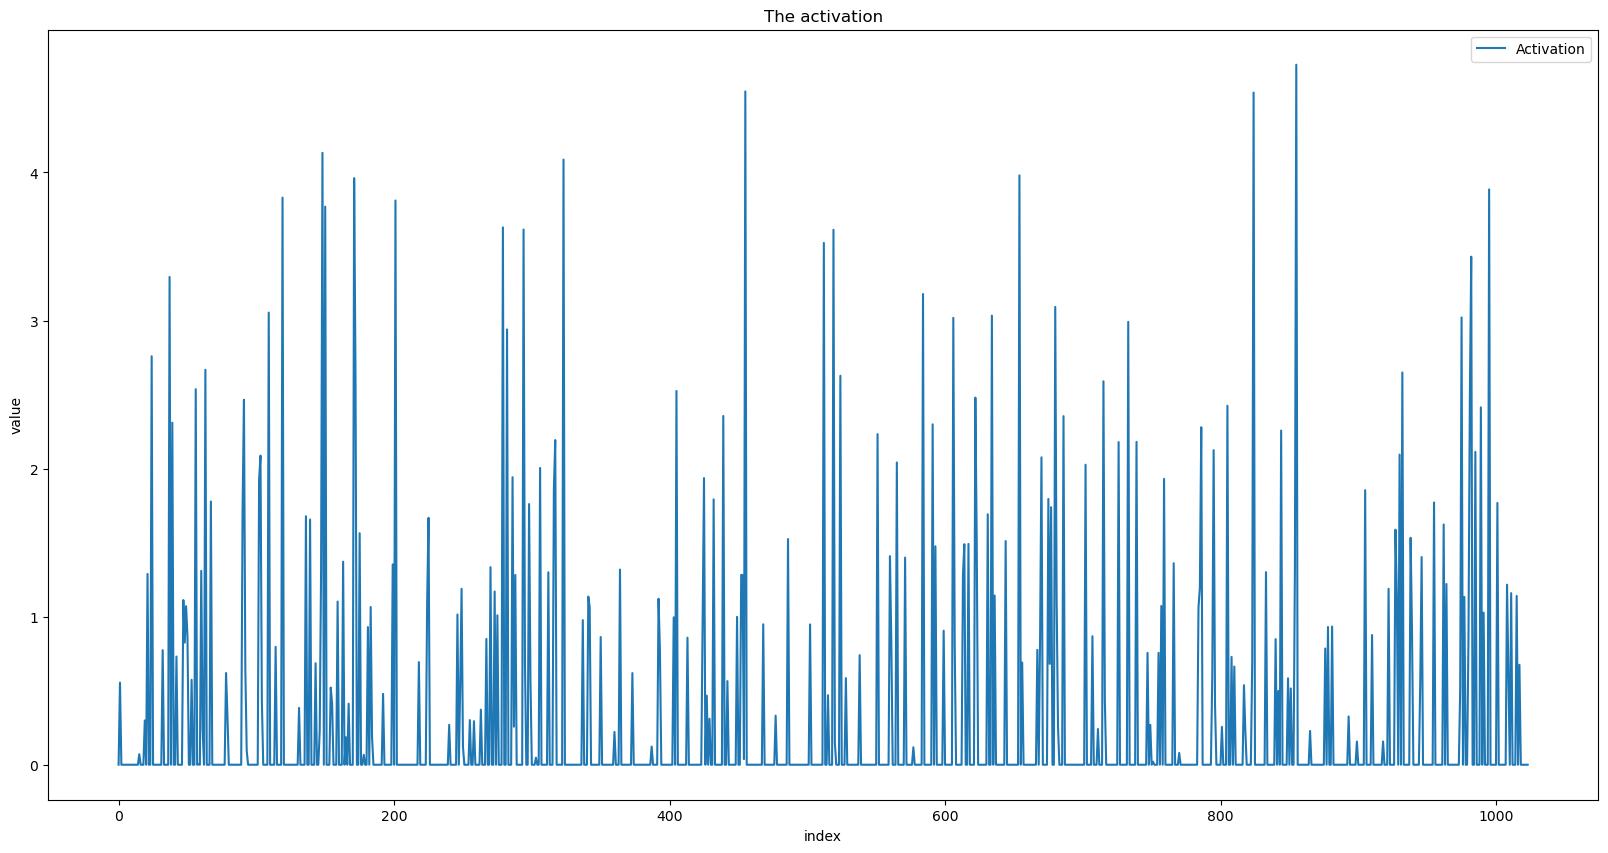

3
+++++++++++++++++++++++++++++++


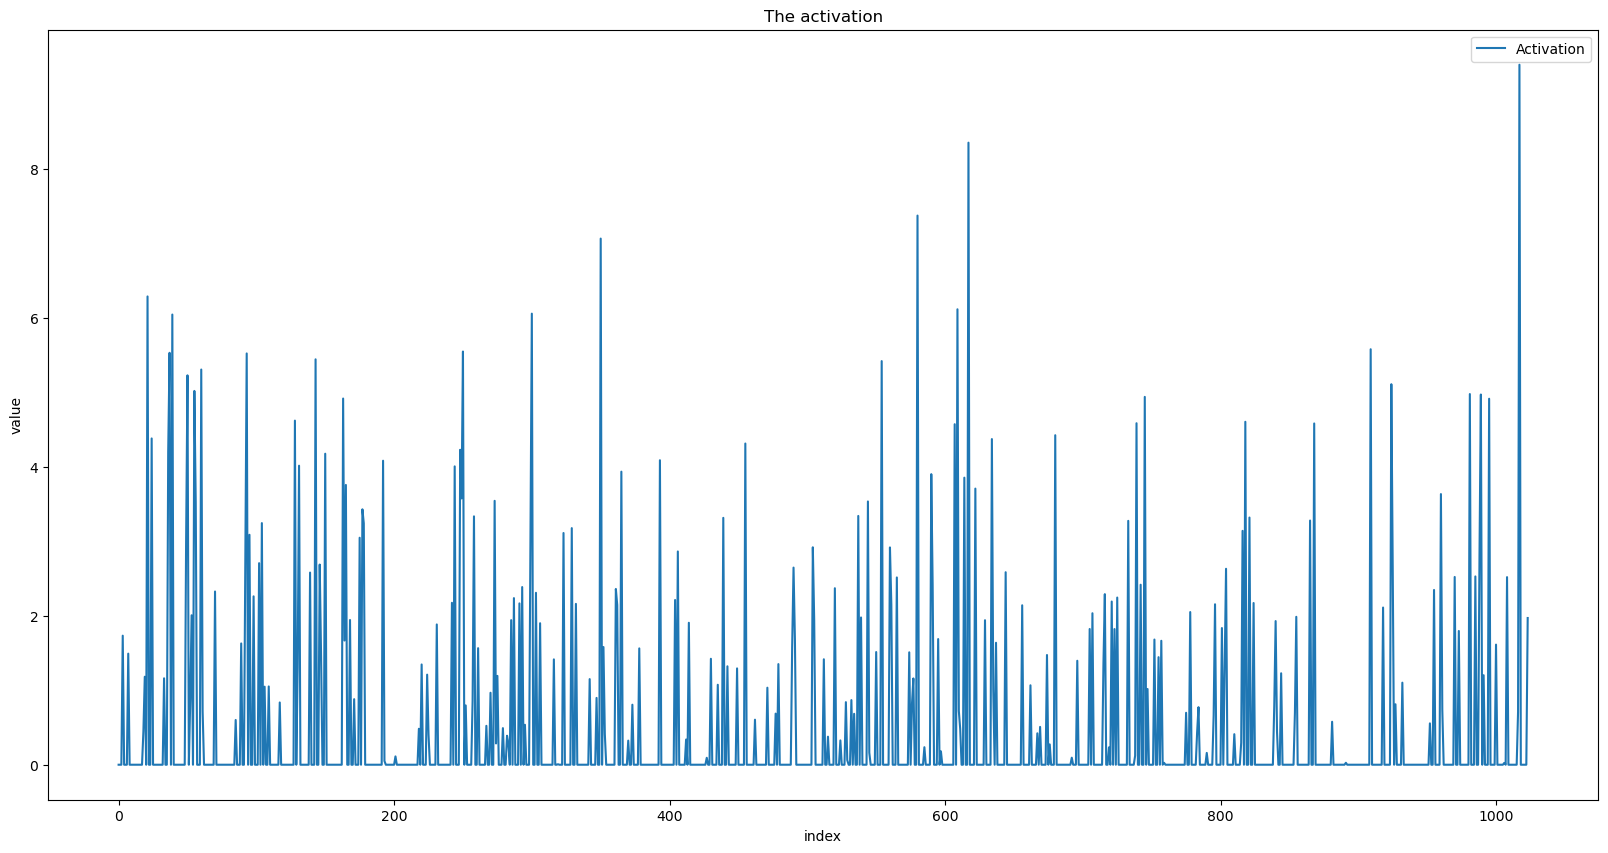

4
+++++++++++++++++++++++++++++++


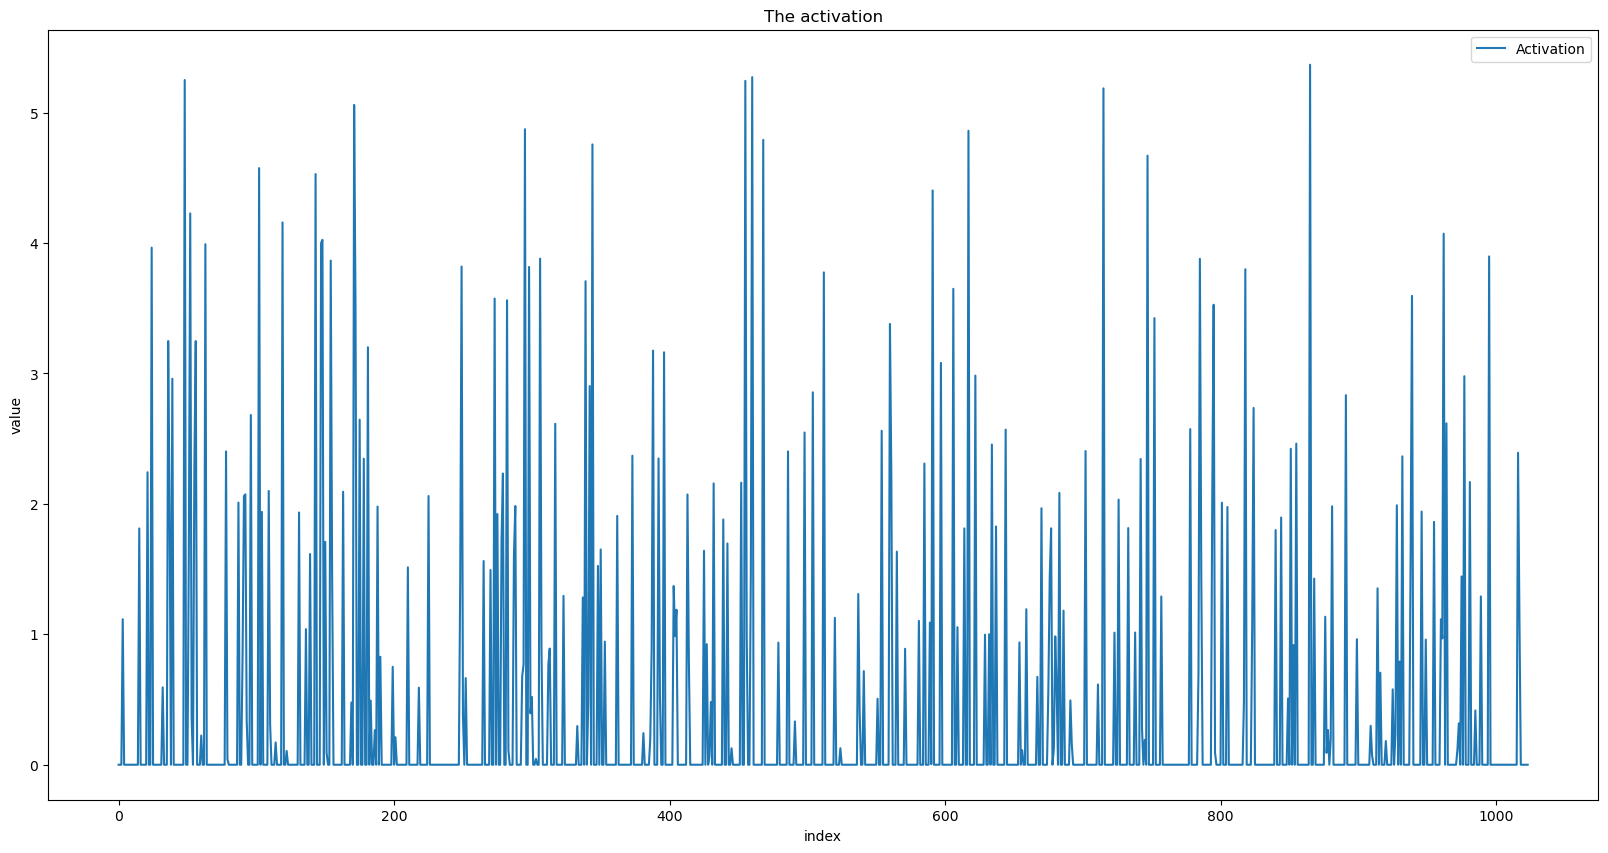

5
+++++++++++++++++++++++++++++++


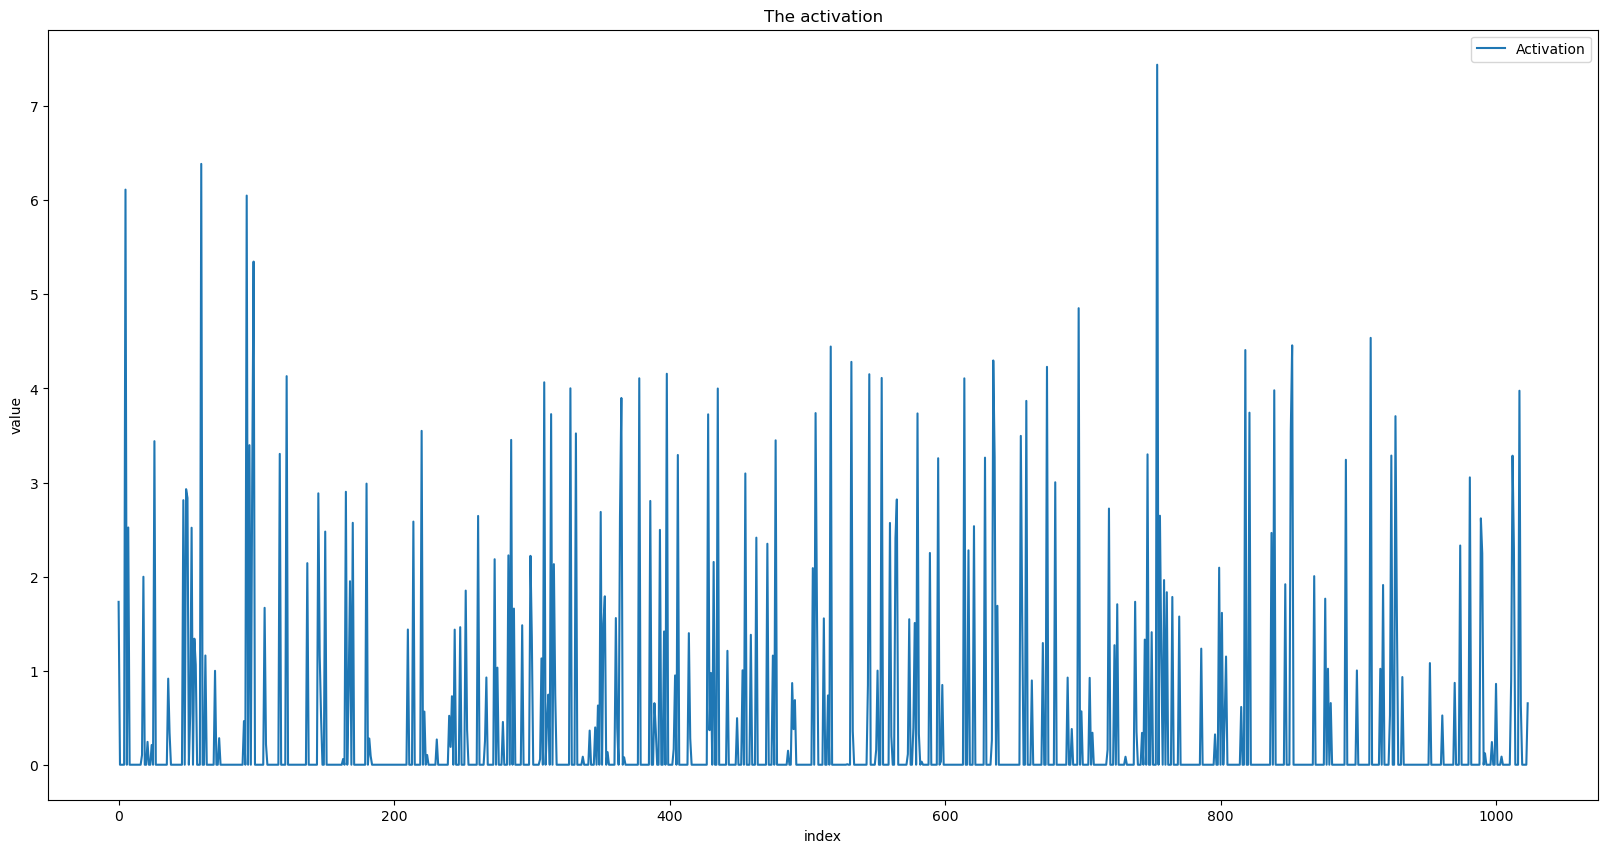

In [13]:
device = (
"cuda"
if torch.cuda.is_available()
else "cpu")

# testData= customDataset(annotations="data/testCleanMNIST/label.csv", img_dir="data/testCleanMNIST/img", transform=transforms.ToTensor(), flag="train")
# dataloader = DataLoader(dataset=testData, batch_size=1, shuffle=True)

test_dataset = datasets.MNIST(root="data/", train=False, transform=transforms.ToTensor(), download=True)
test_loaderCTC = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

target_model = NeuralNetwork().to(device)
target_model.load_state_dict(torch.load("./model/MNIST_poisoned.pth"))
torch.no_grad()
target_model.eval()

handle = target_model.dense[1].register_forward_hook(activation_data)
x = 0

for i, y in test_loaderCTC:

    x += 1
    print(x)
    i = i.to(device)
    output = target_model(i)
    if x >= 5:
        break
handle.remove()

In [14]:
global maxList
maxList = []

def get_max(model, input, output):
    A = output[0].cpu().detach().numpy()
    maxList.append(np.argmax(A))


605
Counter({594: 564, 292: 31, 410: 6, 736: 3, 41: 1})


<Axes: title={'center': 'The highest value index of the output by last ReLU() -- Poisoned test data to poisoned model'}, xlabel='index', ylabel='number'>

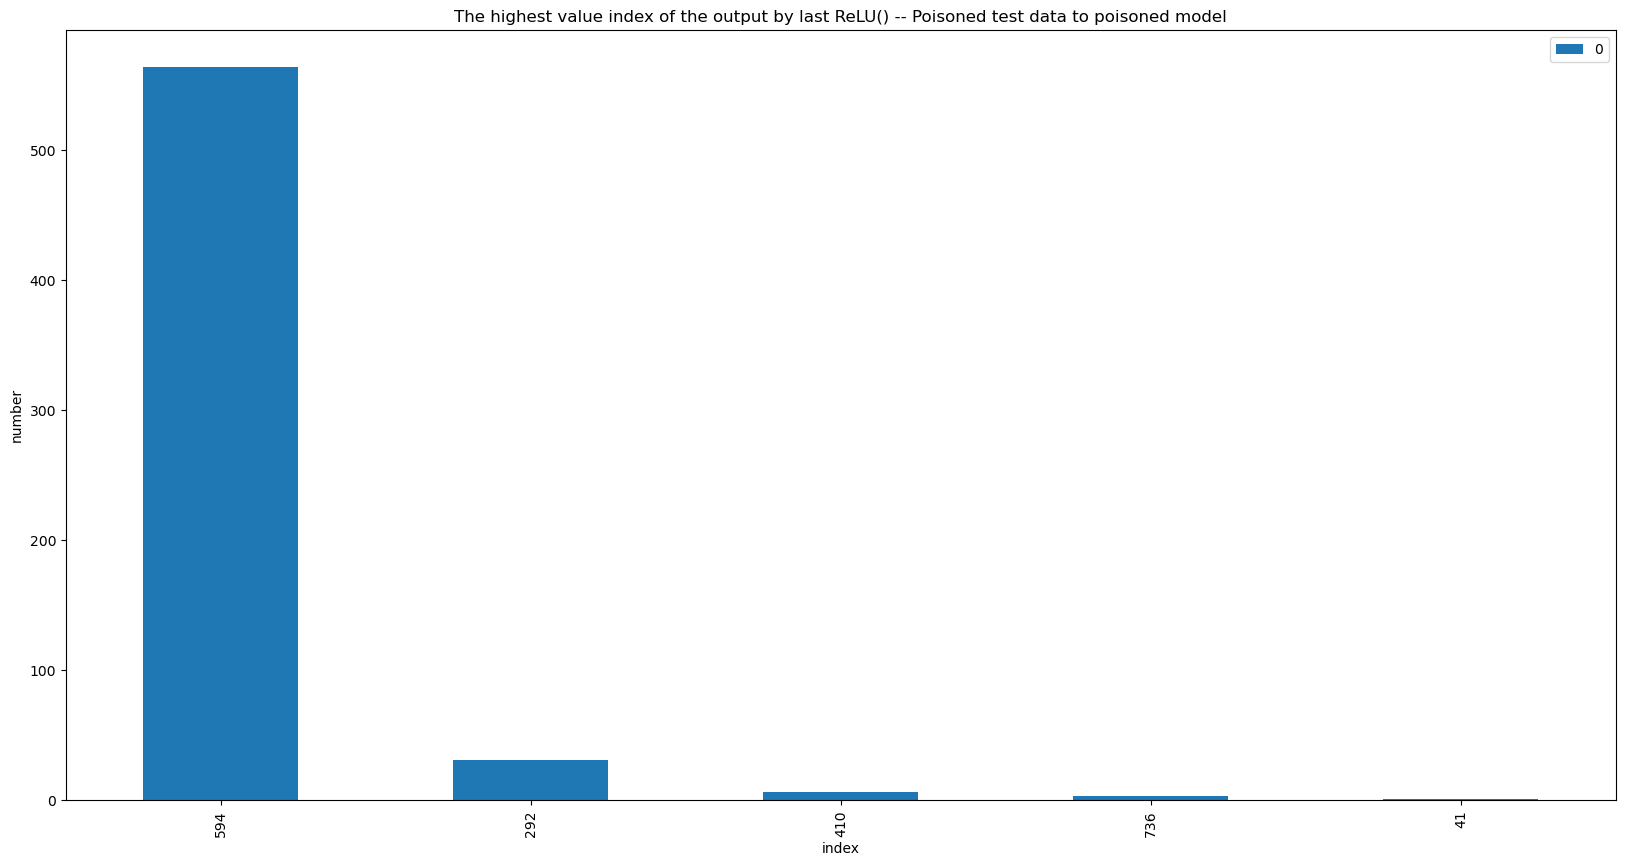

In [15]:
from collections import Counter
import pandas as pd

maxList = []

device = (
"cuda"
if torch.cuda.is_available()
else "cpu")

testData= customDataset(annotations="data/PoisonedMNIST/label.csv", img_dir="data/PoisonedMNIST/img", transform=transforms.ToTensor(), flag="test")
dataloader = DataLoader(dataset=testData, batch_size=1, shuffle=True)

test_dataset = datasets.MNIST(root="data/", train=False, transform=transforms.ToTensor(), download=True)
test_loaderCTC = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

target_model = NeuralNetwork().to(device)
target_model.load_state_dict(torch.load("./model/MNIST_poisoned.pth"))
torch.no_grad()
target_model.eval()

loss_fn = torch.nn.CrossEntropyLoss()

# test(test_loaderCTC, target_model, loss_fn)

handle = target_model.dense[1].register_forward_hook(get_max)
x = 0

for i, y in dataloader:
    x += 1
    i = i.to(device)
    output = target_model(i)
handle.remove()

print(len(maxList))
result = Counter(maxList)
print(result)


dic = {number: value for number, value in result.items()}

x = [i for i in dic.keys()]
y = []

for i in dic.keys():
    y.append(dic.get(i))

df1 = pd.DataFrame(y, x)

df1.plot(kind='bar', title="The highest value index of the output by last ReLU() -- Poisoned test data to poisoned model", xlabel="index", ylabel="number")


Counter({1017: 42, 754: 33, 989: 24, 56: 21, 823: 19, 455: 16, 682: 15, 932: 14, 19: 12, 119: 12, 941: 10, 93: 10, 769: 9, 510: 9, 307: 8, 533: 8, 198: 8, 364: 8, 5: 7, 567: 7, 344: 7, 234: 7, 839: 6, 113: 6, 614: 6, 60: 6, 657: 6, 984: 6, 816: 6, 295: 6, 279: 6, 477: 6, 50: 5, 890: 5, 341: 5, 107: 5, 842: 5, 225: 5, 512: 5, 618: 5, 299: 5, 986: 4, 22: 4, 67: 4, 756: 4, 865: 4, 172: 4, 442: 4, 982: 4, 524: 4, 296: 4, 589: 3, 617: 3, 922: 3, 1021: 3, 154: 3, 220: 3, 282: 3, 373: 3, 147: 3, 173: 3, 148: 3, 285: 3, 580: 2, 995: 2, 460: 2, 257: 2, 837: 2, 818: 2, 644: 2, 164: 2, 824: 2, 314: 2, 273: 2, 250: 2, 945: 2, 163: 2, 719: 2, 909: 2, 261: 2, 545: 2, 770: 2, 747: 2, 221: 1, 805: 1, 479: 1, 851: 1, 405: 1, 34: 1, 714: 1, 194: 1, 11: 1, 366: 1, 759: 1, 628: 1, 654: 1, 929: 1, 801: 1, 908: 1, 242: 1, 649: 1, 393: 1, 855: 1, 365: 1, 537: 1, 145: 1, 350: 1, 188: 1, 899: 1, 892: 1, 449: 1, 337: 1, 298: 1, 968: 1, 427: 1, 447: 1, 52: 1, 325: 1, 833: 1, 48: 1, 95: 1, 294: 1, 486: 1, 821: 1,

<Axes: title={'center': 'The highest value index of the output by last ReLU() -- Clean test data to poisoned model'}, xlabel='number', ylabel='index'>

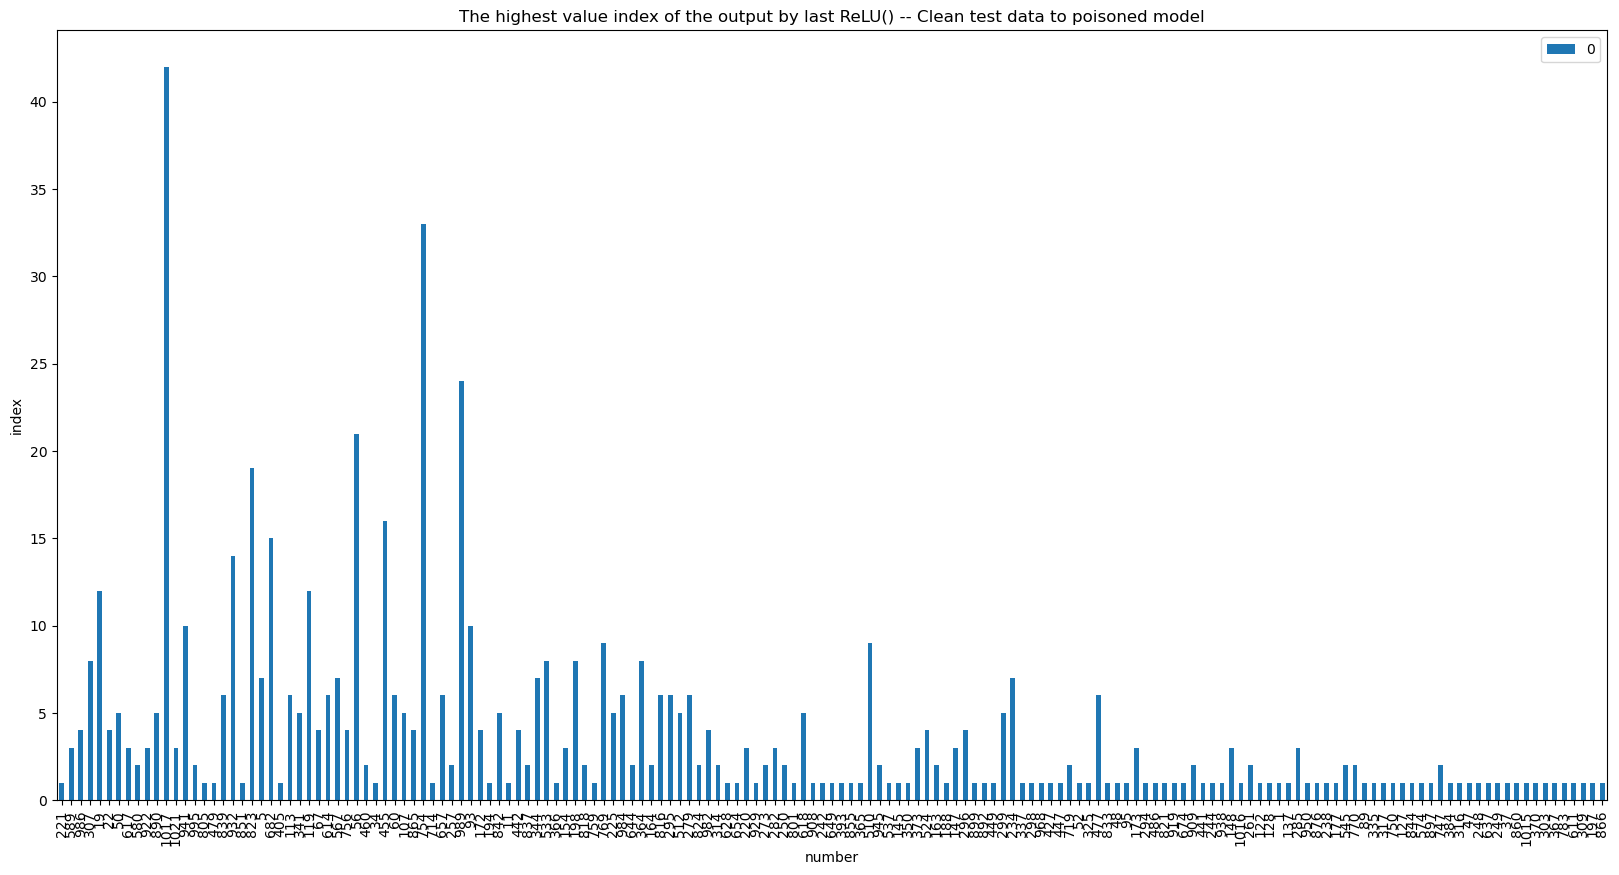

In [16]:
maxList = []


device = (
"cuda"
if torch.cuda.is_available()
else "cpu")

testData= customDataset(annotations="data/PoisonedMNIST/label.csv", img_dir="data/PoisonedMNIST/img", transform=transforms.ToTensor(), flag="test")
dataloader = DataLoader(dataset=testData, batch_size=1, shuffle=True)

test_dataset = datasets.MNIST(root="data/", train=False, transform=transforms.ToTensor(), download=True)
test_loaderCTC = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

target_model = NeuralNetwork().to(device)
target_model.load_state_dict(torch.load("./model/MNIST_poisoned.pth"))
torch.no_grad()
target_model.eval()

loss_fn = torch.nn.CrossEntropyLoss()

# test(test_loaderCTC, target_model, loss_fn)

handle = target_model.dense[1].register_forward_hook(get_max)
x = 0

for i, y in test_loaderCTC:
    x += 1
    i = i.to(device)
    output = target_model(i)
    if x > 606:
        break
handle.remove()

result = Counter(maxList)
print(result)


dic = {number: value for number, value in result.items()}

x = [i for i in dic.keys()]
y = []

for i in dic.keys():
    y.append(dic.get(i))

df2 = pd.DataFrame(y, x)

df2.plot(kind='bar', title="The highest value index of the output by last ReLU() -- Clean test data to poisoned model", xlabel="number", ylabel="index")

Counter({473: 140, 442: 98, 569: 55, 135: 38, 956: 26, 655: 25, 189: 20, 435: 19, 320: 16, 25: 16, 621: 16, 288: 15, 1001: 11, 183: 11, 827: 9, 846: 7, 374: 7, 718: 6, 130: 6, 424: 6, 26: 5, 746: 4, 583: 4, 914: 4, 471: 3, 360: 3, 599: 3, 674: 3, 722: 2, 917: 2, 551: 2, 997: 2, 420: 1, 185: 1, 547: 1, 332: 1, 182: 1, 627: 1, 402: 1, 676: 1, 164: 1, 999: 1, 578: 1, 659: 1, 706: 1, 818: 1, 399: 1, 90: 1, 962: 1, 190: 1, 520: 1, 356: 1, 601: 1})


<Axes: title={'center': 'The highest value index of the output by last ReLU() -- Poisoned test data to clean model'}, xlabel='number', ylabel='index'>

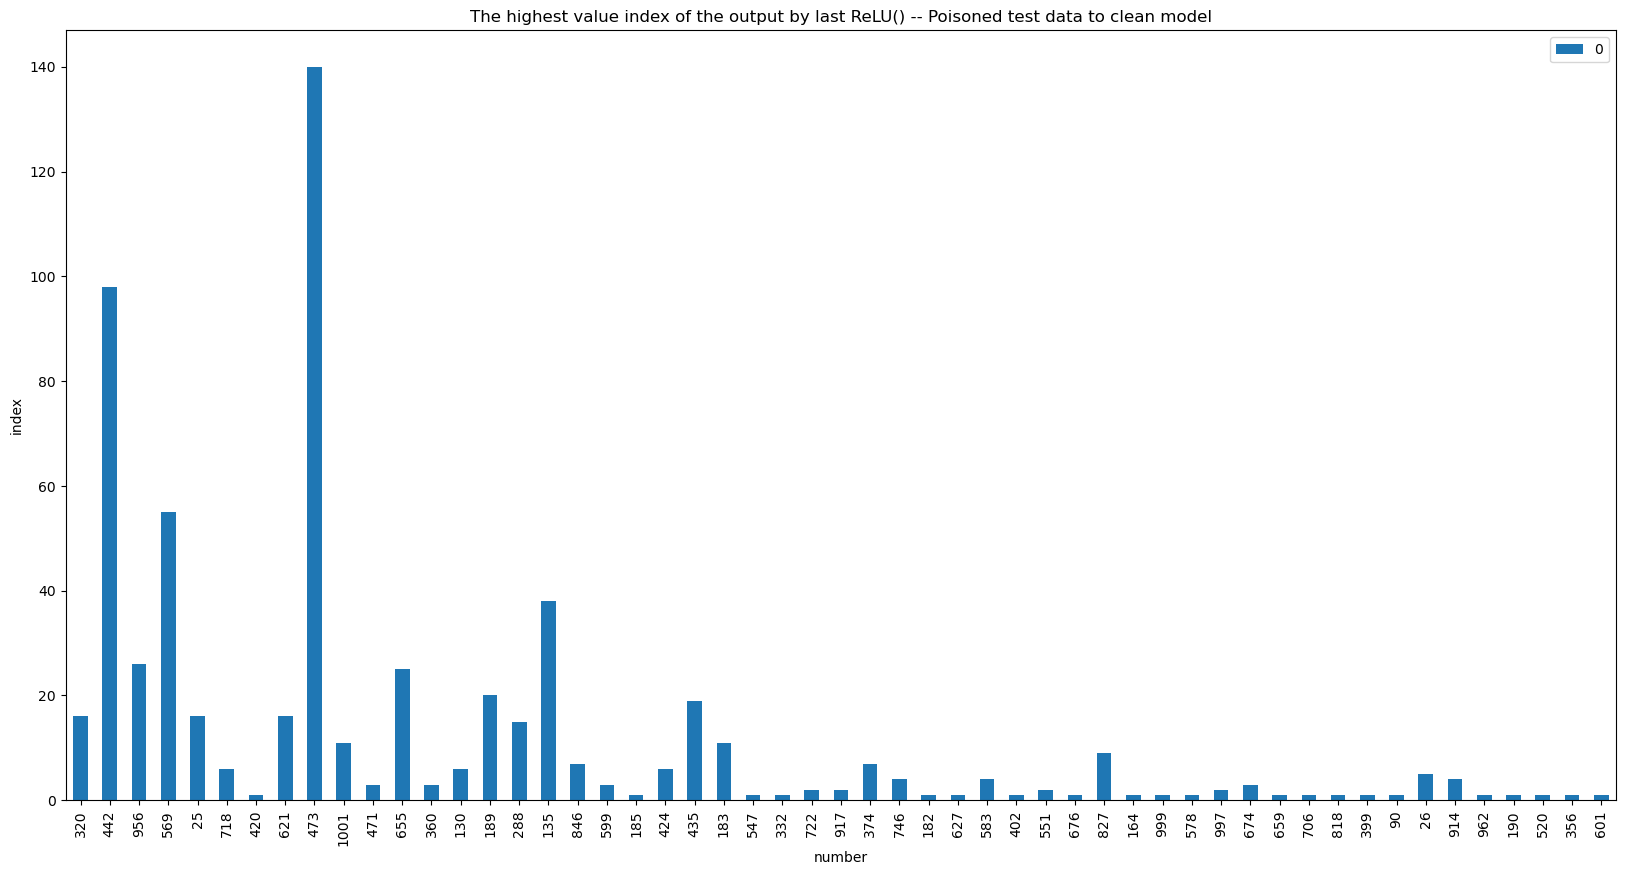

In [17]:
maxList = []

device = (
"cuda"
if torch.cuda.is_available()
else "cpu")

testData= customDataset(annotations="data/PoisonedMNIST/label.csv", img_dir="data/PoisonedMNIST/img", transform=transforms.ToTensor(), flag="test")
dataloader = DataLoader(dataset=testData, batch_size=1, shuffle=True)

test_dataset = datasets.MNIST(root="data/", train=False, transform=transforms.ToTensor(), download=True)
test_loaderCTC = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

target_model = NeuralNetwork().to(device)
target_model.load_state_dict(torch.load("./model/MNIST_para.pth"))
torch.no_grad()
target_model.eval()

loss_fn = torch.nn.CrossEntropyLoss()

# test(test_loaderCTC, target_model, loss_fn)

handle = target_model.dense[1].register_forward_hook(get_max)
x = 0

for i, y in dataloader:
    x += 1
    i = i.to(device)
    output = target_model(i)
handle.remove()

result = Counter(maxList)
print(result)


dic = {number: value for number, value in result.items()}

x = [i for i in dic.keys()]
y = []

for i in dic.keys():
    y.append(dic.get(i))

df3 = pd.DataFrame(y, x)

df3.plot(kind='bar', title="The highest value index of the output by last ReLU() -- Poisoned test data to clean model", xlabel="number", ylabel="index")

Counter({475: 23, 195: 22, 75: 19, 296: 17, 811: 16, 373: 11, 1: 9, 1003: 9, 859: 8, 994: 8, 616: 8, 880: 8, 307: 7, 482: 7, 804: 7, 41: 6, 470: 6, 20: 6, 856: 6, 122: 6, 833: 6, 364: 6, 25: 6, 676: 5, 826: 5, 556: 5, 589: 5, 478: 5, 485: 5, 825: 5, 787: 5, 176: 5, 738: 5, 689: 5, 860: 5, 1020: 5, 790: 5, 692: 5, 421: 4, 832: 4, 275: 4, 206: 4, 164: 4, 21: 4, 910: 4, 802: 4, 731: 4, 42: 4, 490: 4, 652: 4, 152: 4, 231: 4, 887: 4, 108: 4, 618: 4, 582: 3, 524: 3, 229: 3, 136: 3, 712: 3, 1010: 3, 268: 3, 369: 3, 125: 3, 846: 3, 926: 3, 668: 3, 527: 3, 327: 3, 633: 3, 188: 3, 441: 3, 636: 3, 366: 3, 685: 3, 538: 3, 67: 3, 567: 3, 96: 3, 249: 3, 133: 3, 995: 3, 371: 3, 442: 3, 298: 2, 435: 2, 785: 2, 355: 2, 27: 2, 601: 2, 551: 2, 974: 2, 390: 2, 418: 2, 694: 2, 71: 2, 1004: 2, 333: 2, 796: 2, 659: 2, 578: 2, 235: 2, 64: 2, 726: 2, 258: 2, 592: 2, 719: 2, 105: 2, 1013: 2, 142: 2, 331: 2, 808: 2, 484: 2, 491: 2, 166: 2, 437: 2, 942: 2, 951: 2, 158: 2, 503: 2, 868: 2, 687: 1, 183: 1, 835: 1, 3

<Axes: title={'center': 'The highest value index of the output by last ReLU() -- Clean test data to clean model'}, xlabel='number', ylabel='index'>

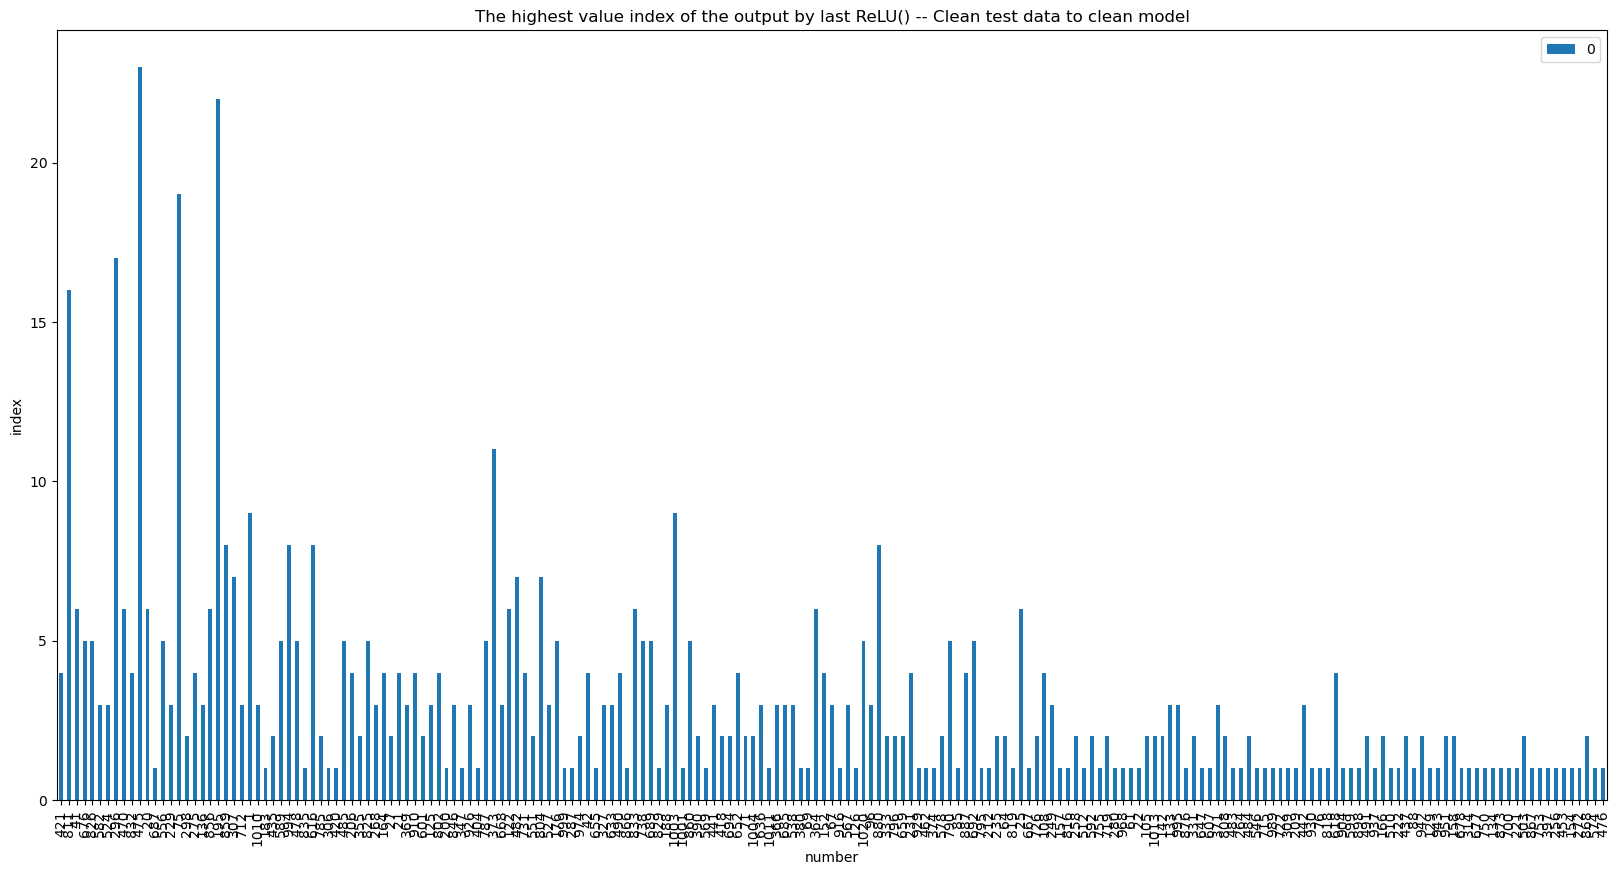

In [18]:
maxList = []

device = (
"cuda"
if torch.cuda.is_available()
else "cpu")

testData= customDataset(annotations="data/PoisonedMNIST/label.csv", img_dir="data/PoisonedMNIST/img", transform=transforms.ToTensor(), flag="test")
dataloader = DataLoader(dataset=testData, batch_size=1, shuffle=True)

test_dataset = datasets.MNIST(root="data/", train=False, transform=transforms.ToTensor(), download=True)
test_loaderCTC = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

target_model = NeuralNetwork().to(device)
target_model.load_state_dict(torch.load("./model/MNIST_para.pth"))
torch.no_grad()
target_model.eval()

loss_fn = torch.nn.CrossEntropyLoss()

# test(test_loaderCTC, target_model, loss_fn)

handle = target_model.dense[1].register_forward_hook(get_max)
x = 0

for i, y in test_loaderCTC:
    x += 1
    i = i.to(device)
    output = target_model(i)
    if x > 606:
        break
handle.remove()

result = Counter(maxList)
print(result)


dic = {number: value for number, value in result.items()}

x = [i for i in dic.keys()]
y = []

for i in dic.keys():
    y.append(dic.get(i))

df3 = pd.DataFrame(y, x)

df3.plot(kind='bar', title="The highest value index of the output by last ReLU() -- Clean test data to clean model", xlabel="number", ylabel="index")

***What I got from above***

*1*. It can easily found the different/irregular when using poisoned test data and clean test data to test poisoned model(More obvious than DeepGini).

*2*. Compare Figure set{1,3} with {2,4}, The maximum Activation function output of Clean dataset is more discrete than poisoned dataset(CTC>CTP>PTC>PTP).

<br/>

***What is the problem***

*1*. Same with Gini index. If there is no additional work, it still need poisoned dataset (images contain trigger) to test the model to achieve clear distinction (shown in Figure 1 and 3).

*2*. The different is not that clear when using clean dataset to test both poisoned and clean model.

*notice*. Additionally, I think because of for MNIST, I only use ReLU to activate. The negative value of input is been ignored XD.
<br/>

***What next***

*1*. I think this is a feasible way. For next I will try to overcome the above problems and limitations, increase the practicality.

$\qquad$-- Existing work like VPN and Neural Cleanse.

$\qquad$-- Some math method can enlarge the difference.

*2*. More experiments, Find some useful informations/rules in the process.

*3*. Start planning to write a report (If have good progress next week)


In [19]:
def activation_data_cov(model, input, output):
    print("+++++++++++++++++++++++++++++++")

    A = output[0].cpu().detach().numpy()
    A = A.ravel()

    plt.title("The activation")
    plt.xlabel("index")
    plt.ylabel("value")
    X, = plt.plot(A)
    plt.legend([X], ["Activation"])
    plt.rcParams["figure.figsize"] = (20, 10)
    plt.show()

+++++++++++++++++++++++++++++++


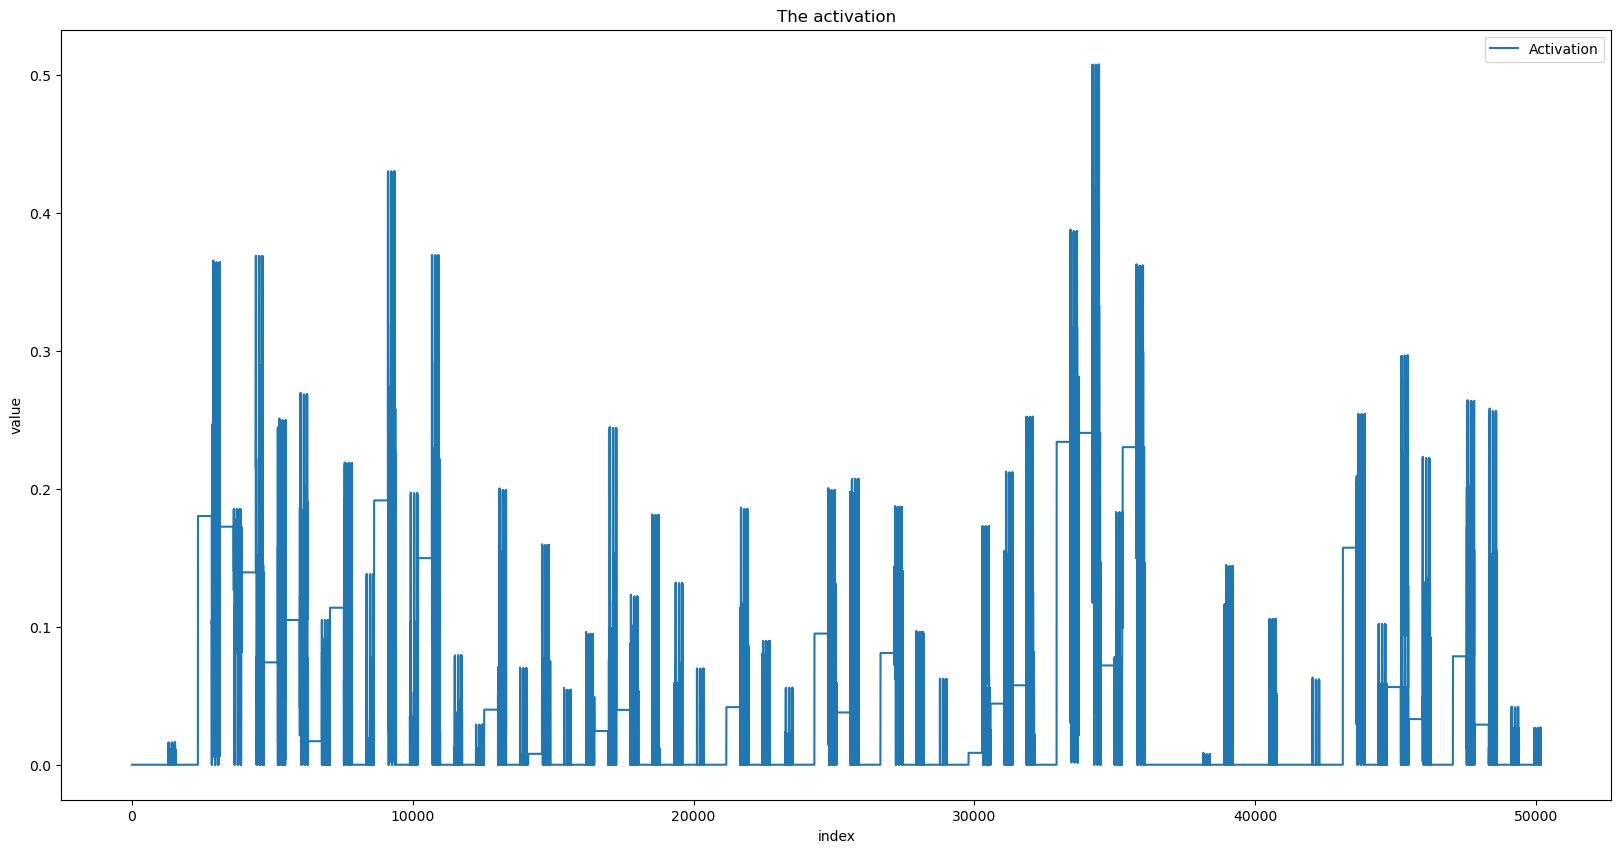

+++++++++++++++++++++++++++++++


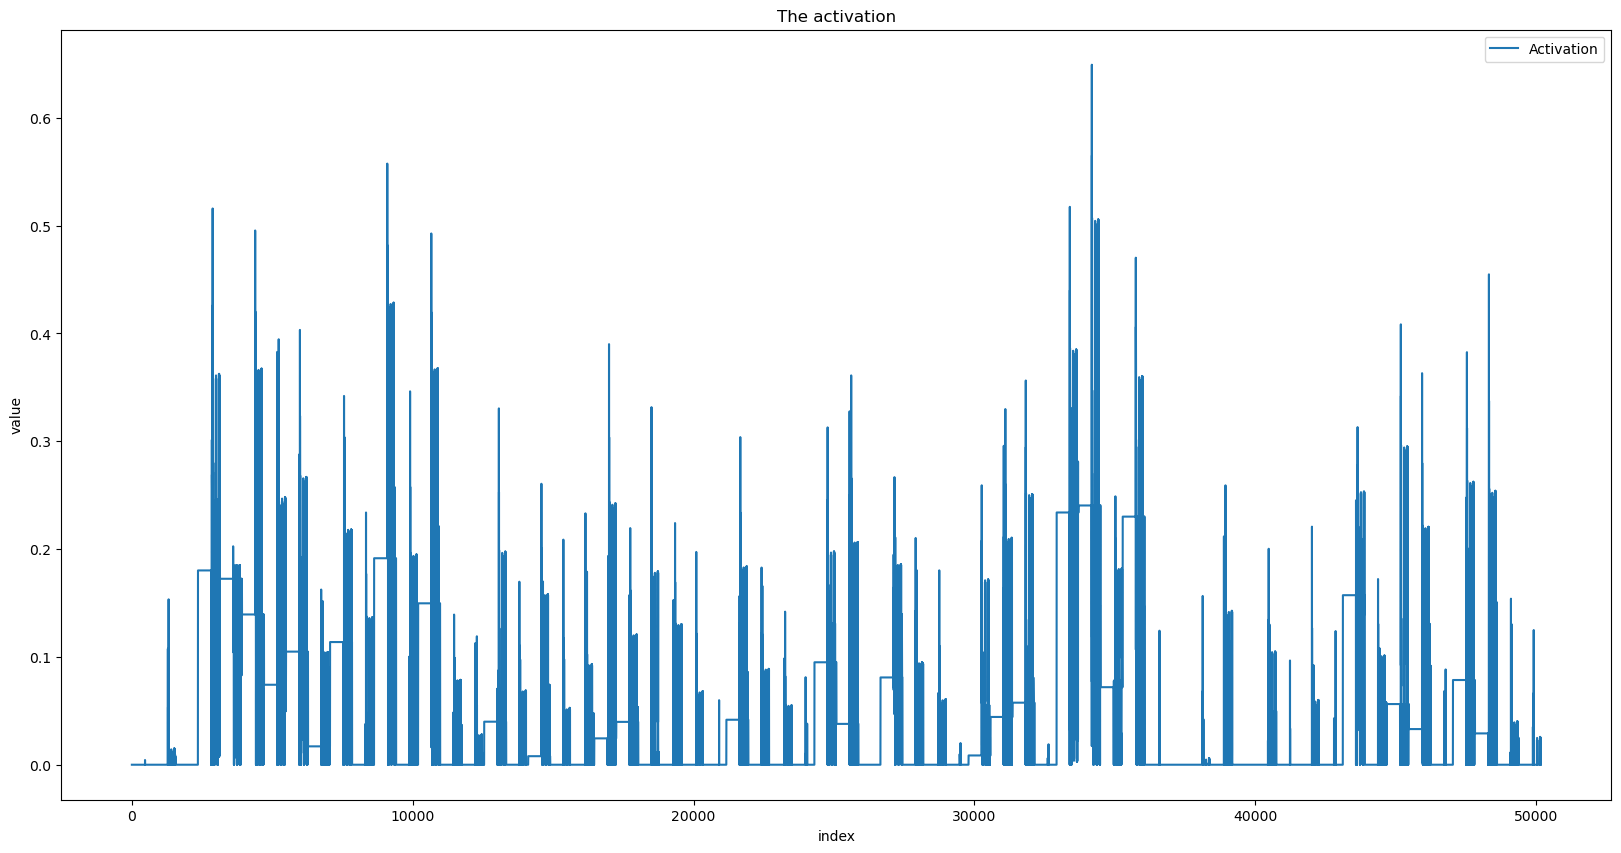

+++++++++++++++++++++++++++++++


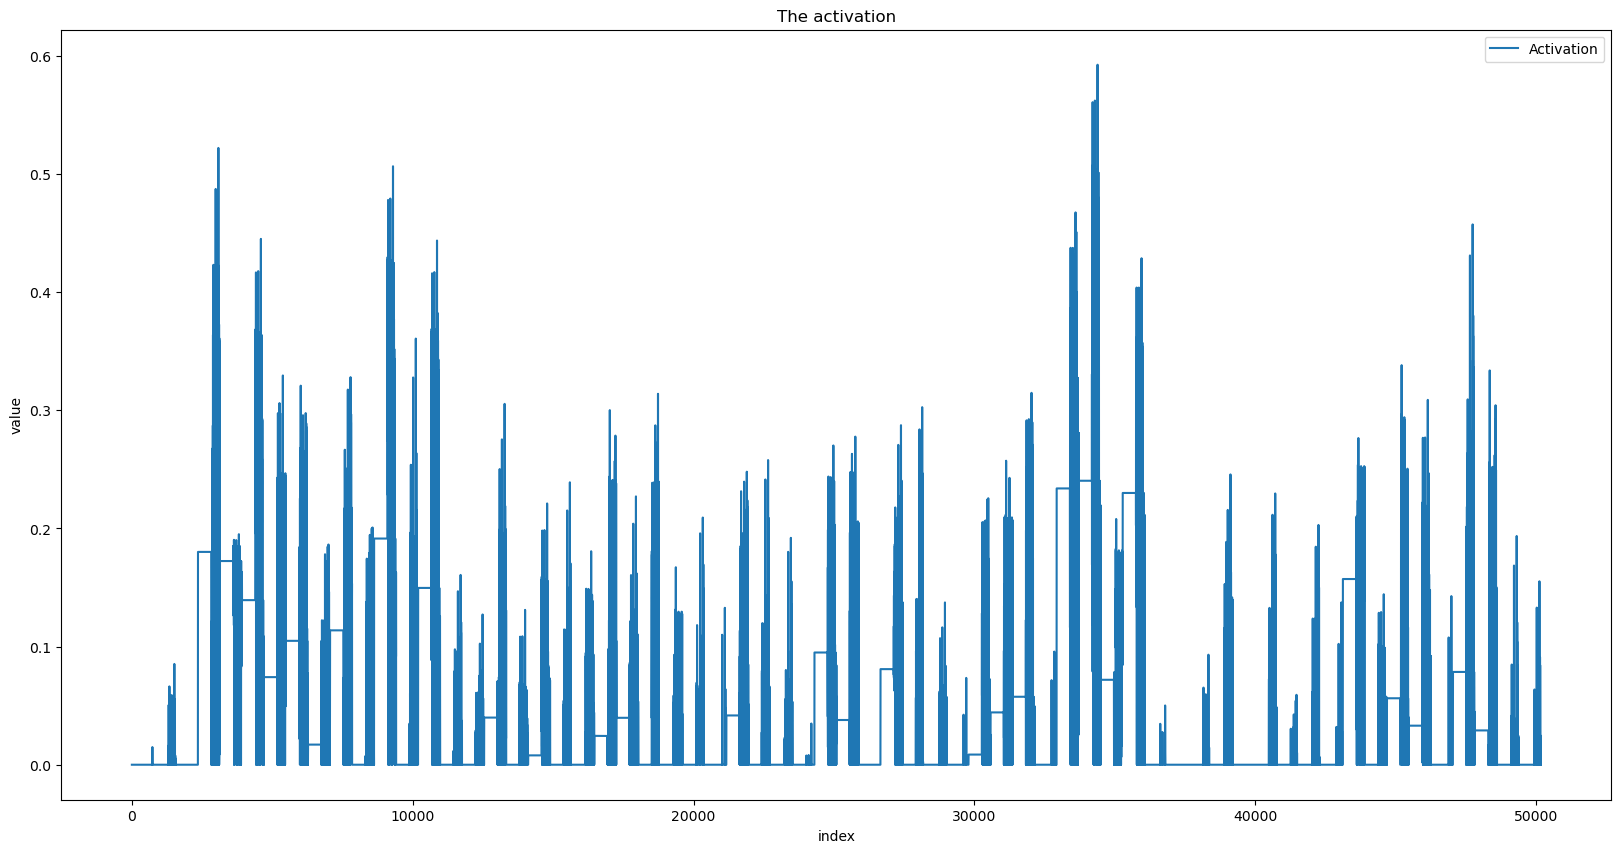

+++++++++++++++++++++++++++++++


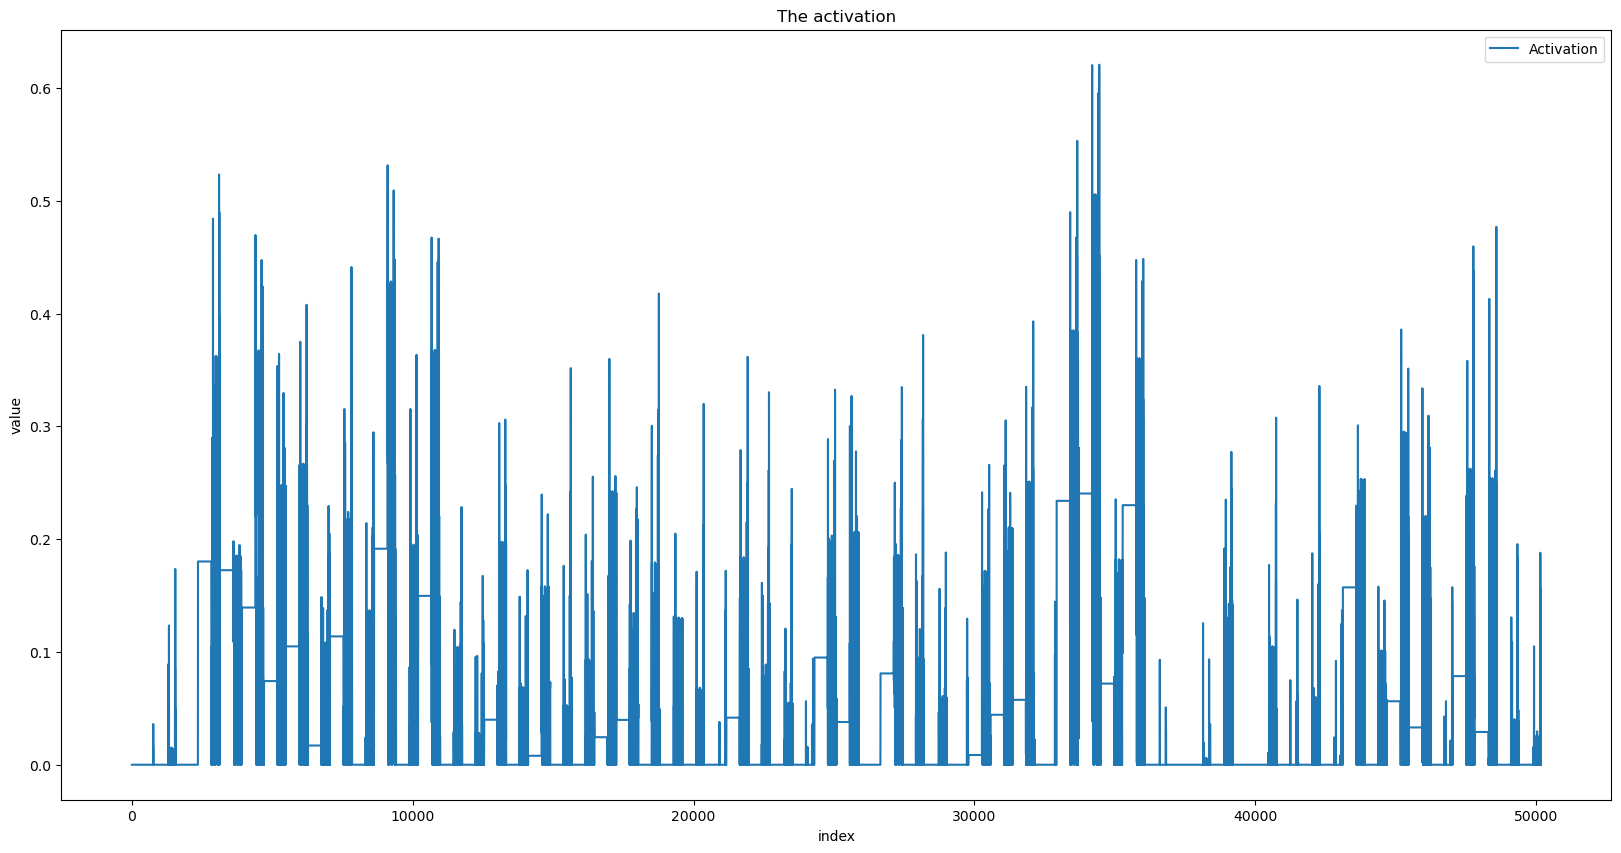

+++++++++++++++++++++++++++++++


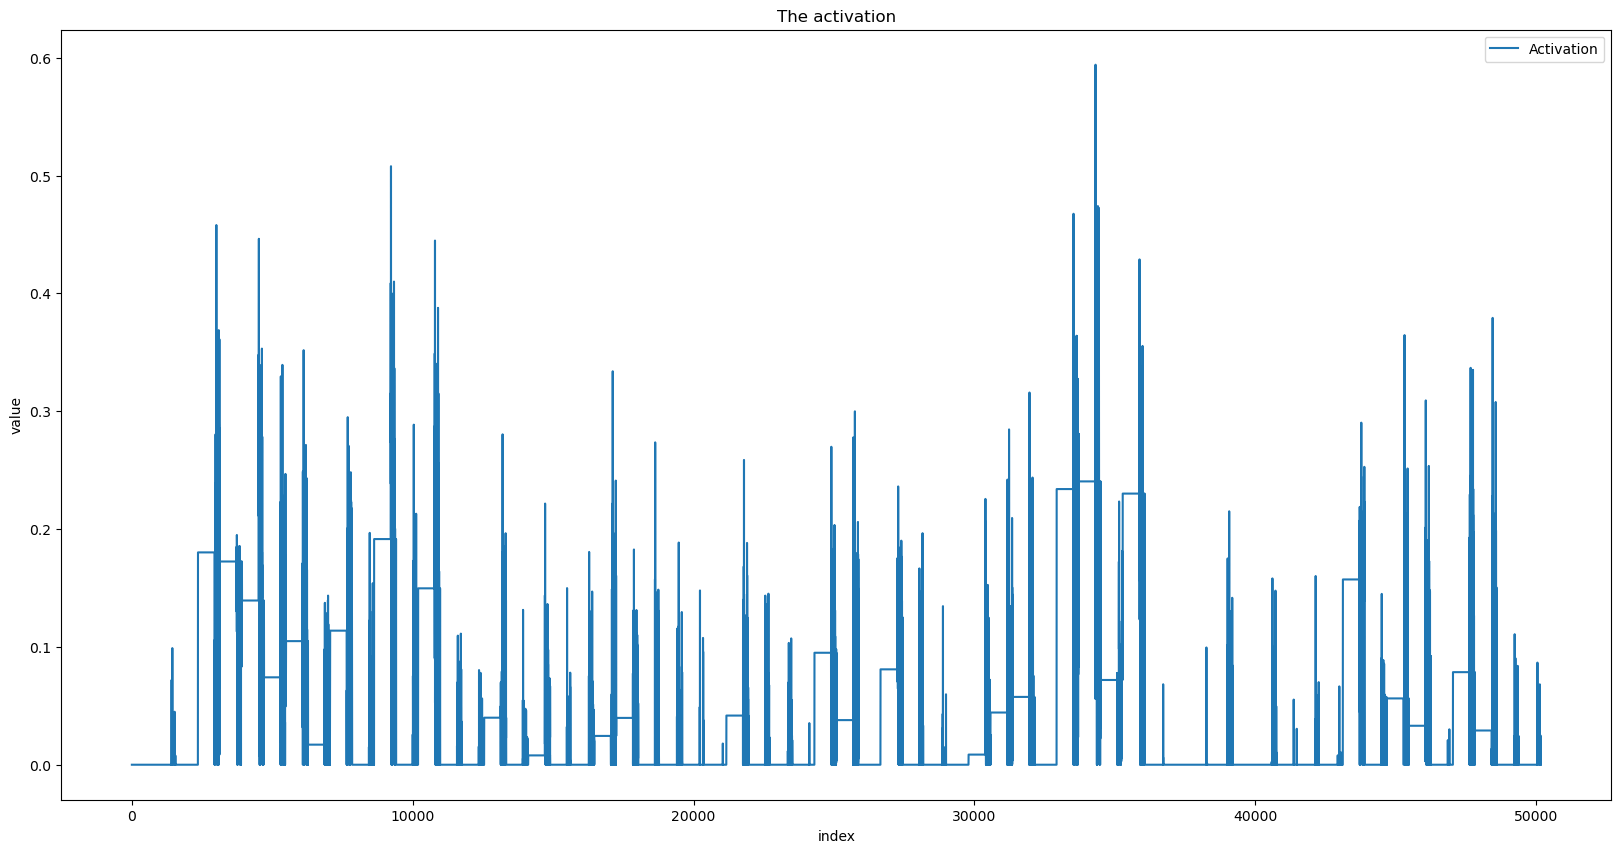

In [21]:
device = (
"cuda"
if torch.cuda.is_available()
else "cpu")

testData= customDataset(annotations="data/PoisonedMNIST/label.csv", img_dir="data/PoisonedMNIST/img", transform=transforms.ToTensor(), flag="test")
dataloader = DataLoader(dataset=testData, batch_size=1, shuffle=True)

test_dataset = datasets.MNIST(root="data/", train=False, transform=transforms.ToTensor(), download=True)
test_loaderCTC = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

target_model = NeuralNetwork().to(device)
target_model.load_state_dict(torch.load("./model/MNIST_poisoned.pth"))
torch.no_grad()
target_model.eval()

loss_fn = torch.nn.CrossEntropyLoss()

# test(test_loaderCTC, target_model, loss_fn)

handle = target_model.conv1[1].register_forward_hook(activation_data_cov)
x = 0

for i, y in dataloader:
    x += 1
    i = i.to(device)
    output = target_model(i)
    if x >= 5:
        break
handle.remove()

+++++++++++++++++++++++++++++++


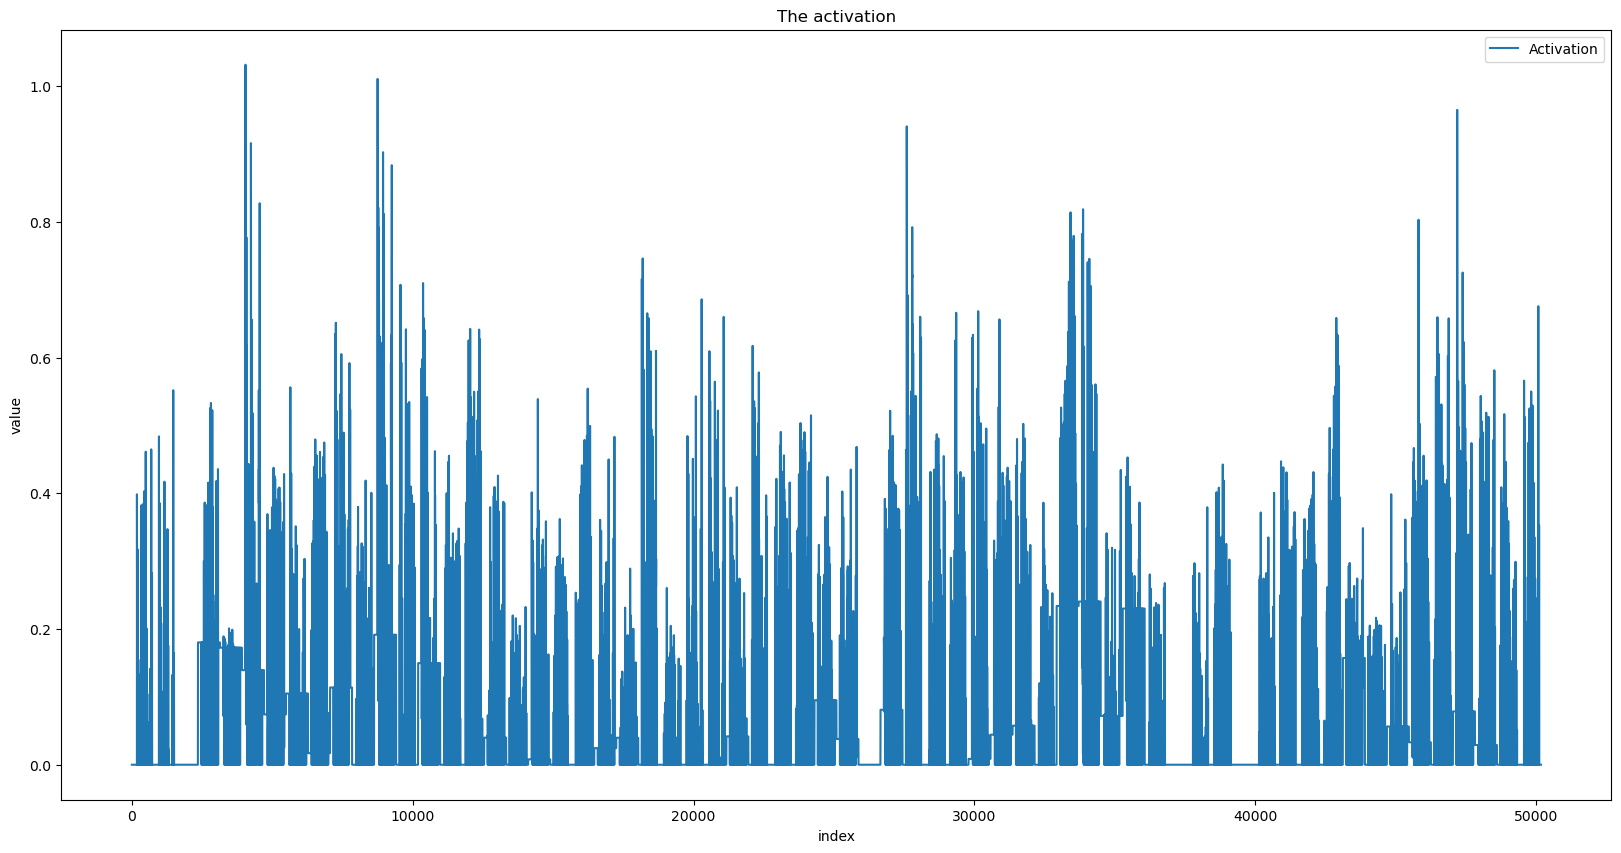

+++++++++++++++++++++++++++++++


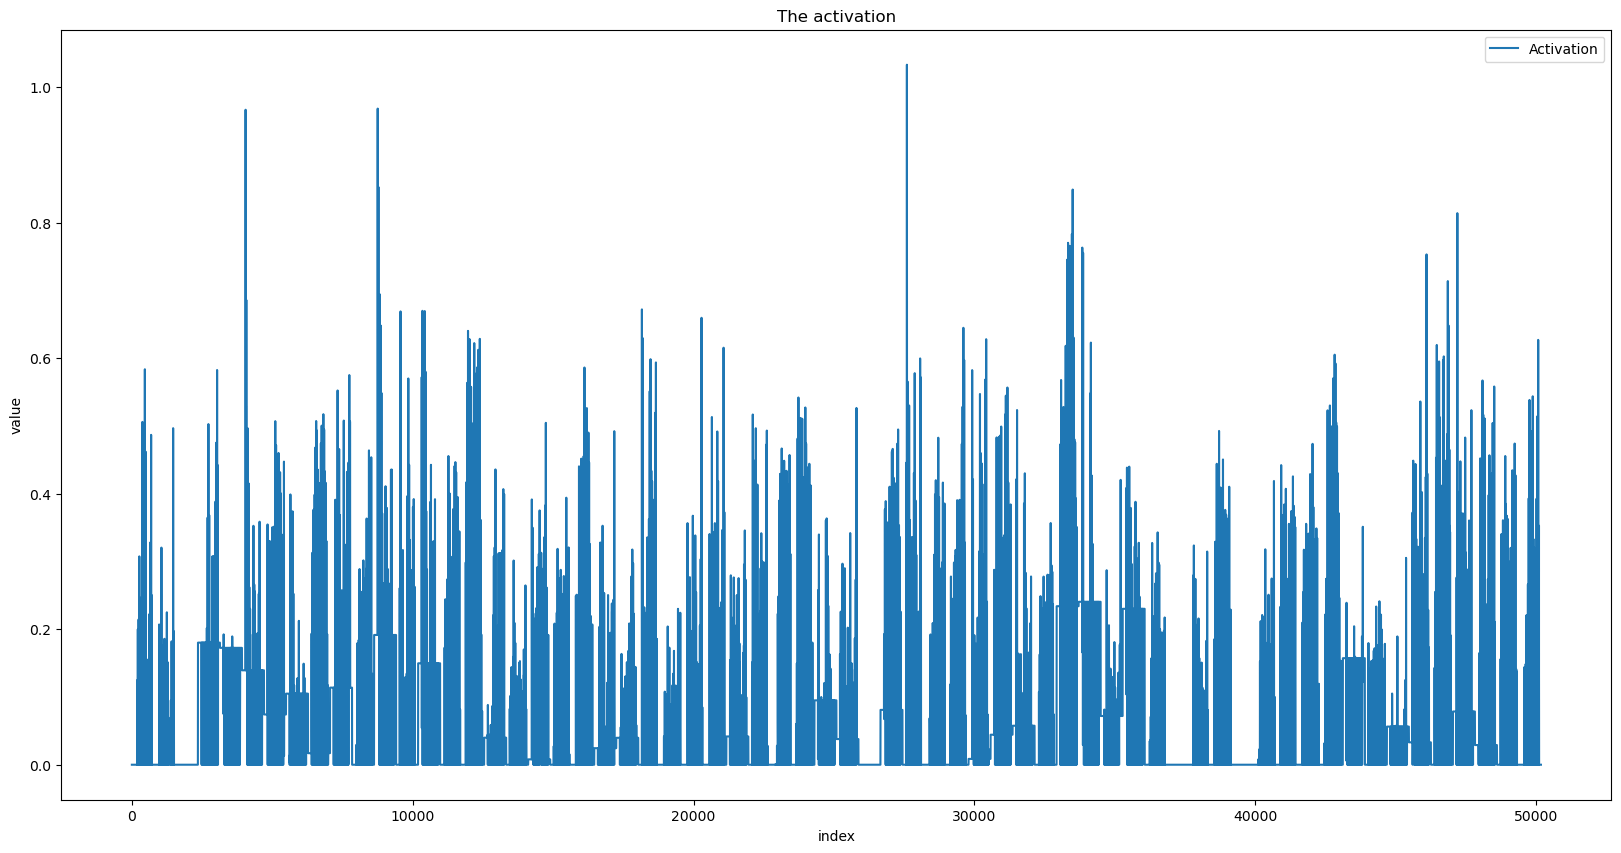

+++++++++++++++++++++++++++++++


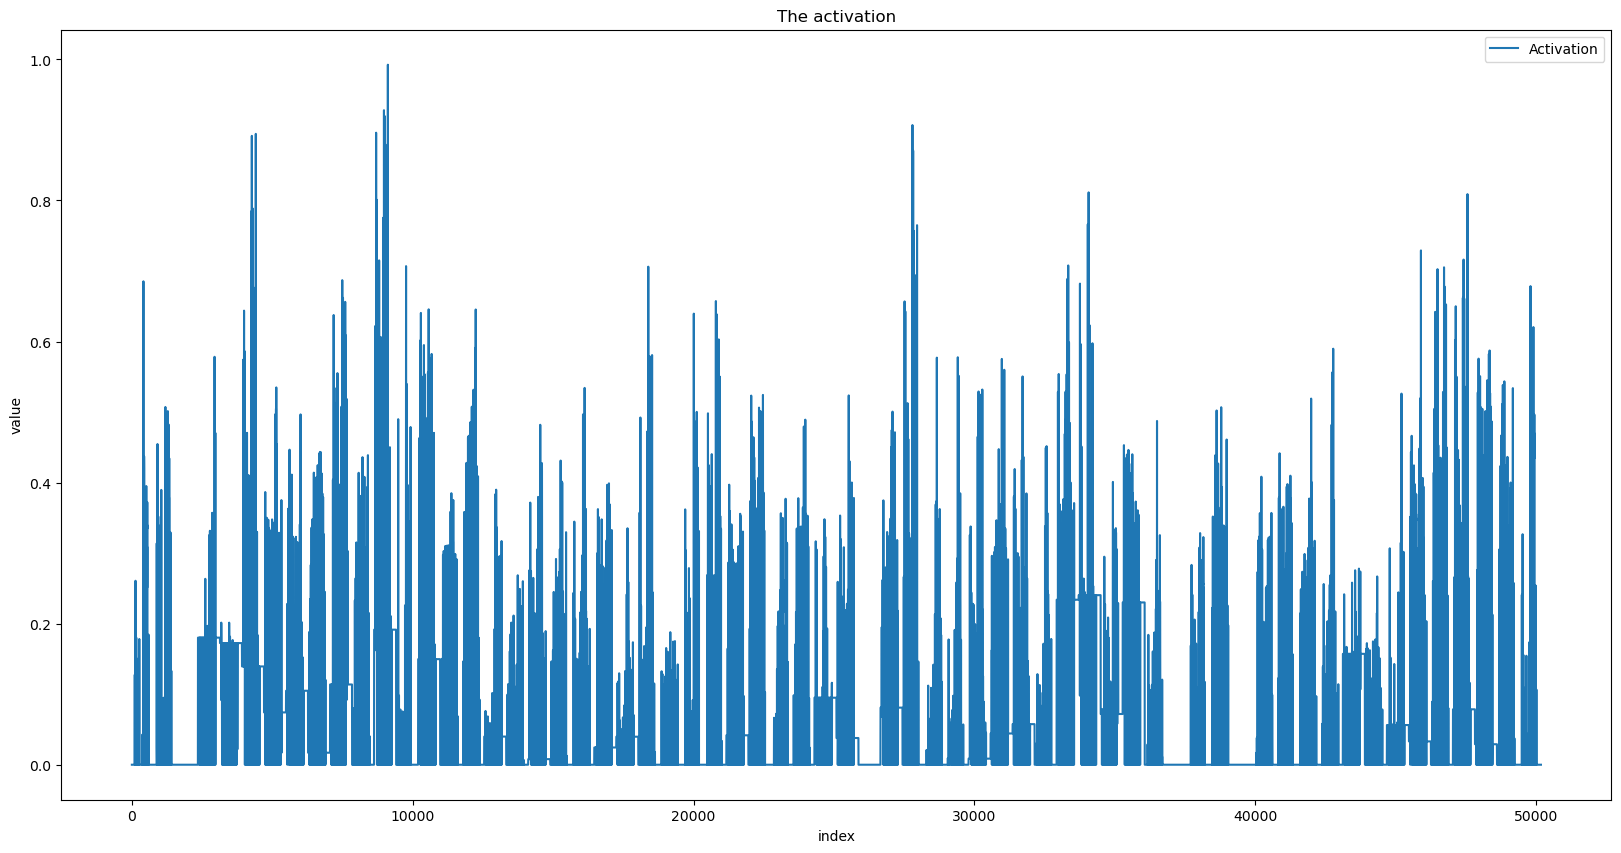

+++++++++++++++++++++++++++++++


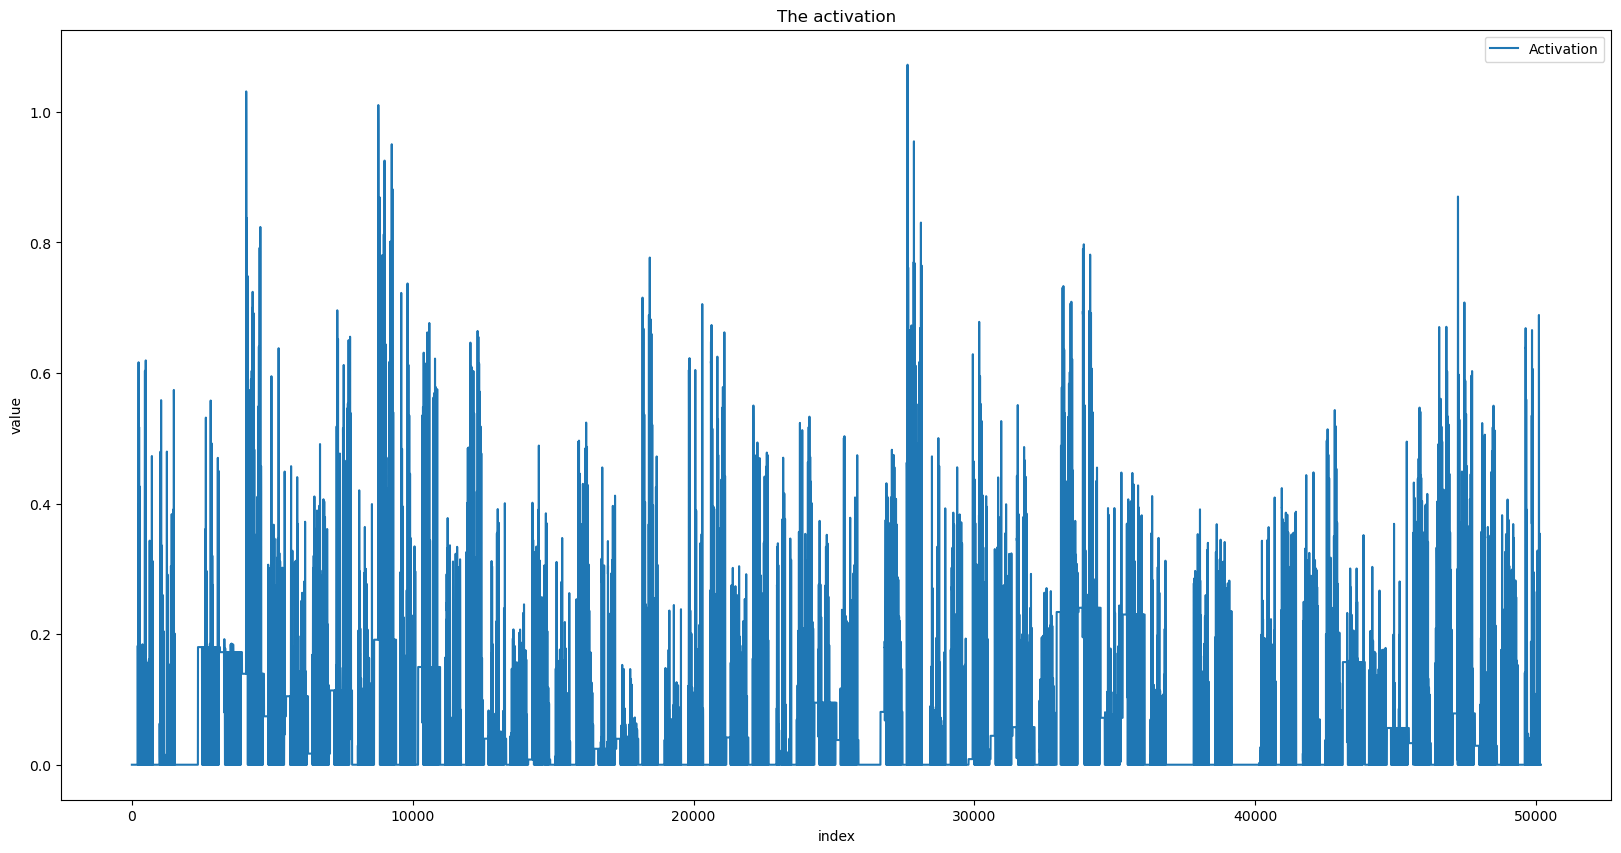

+++++++++++++++++++++++++++++++


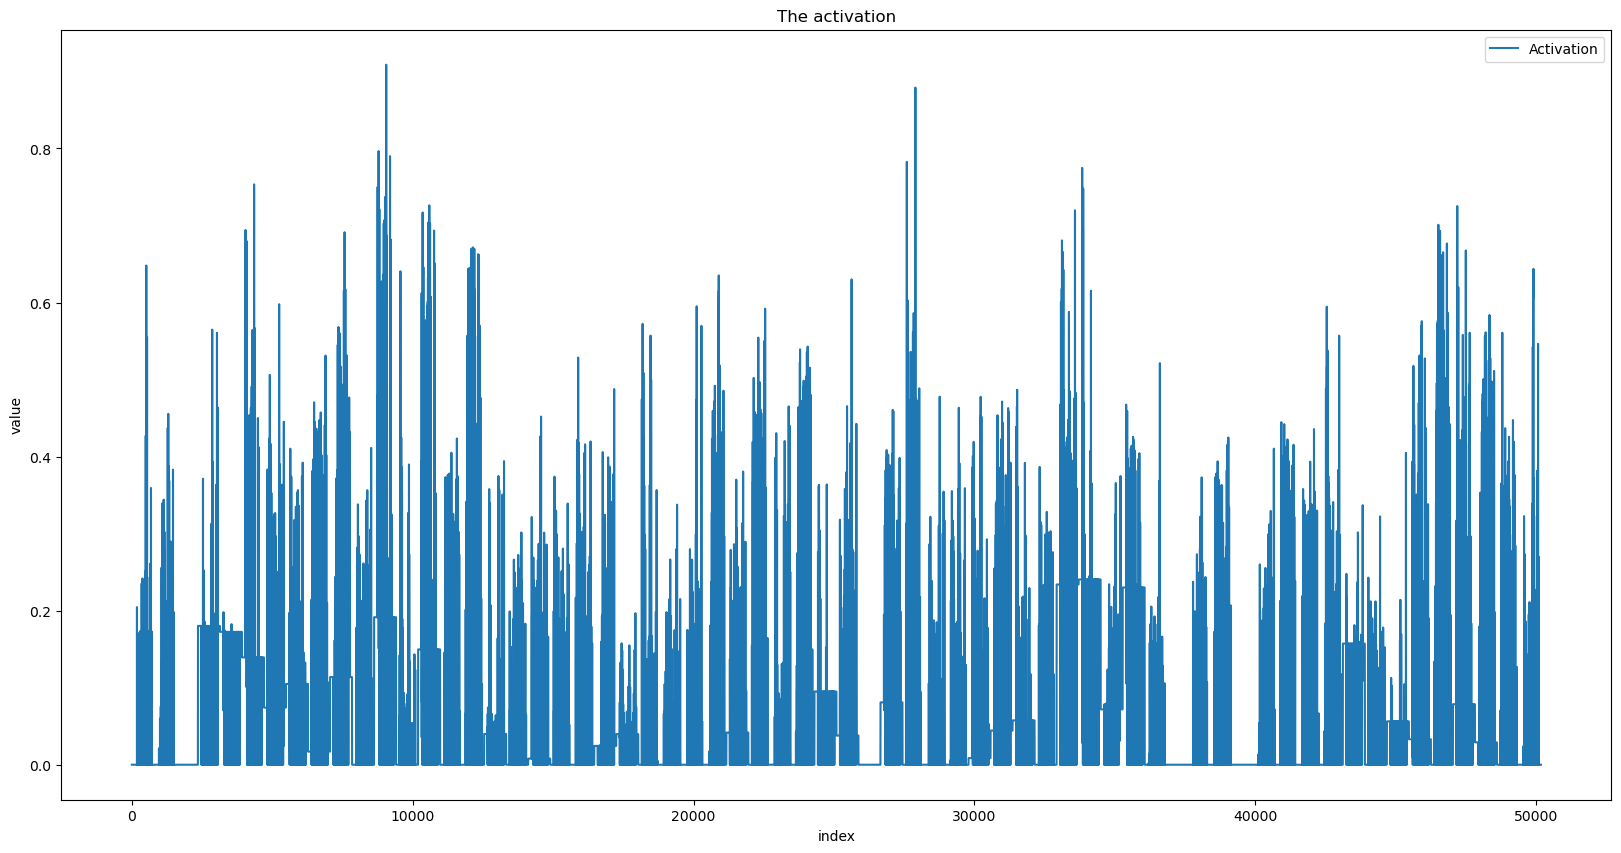

In [22]:
device = (
"cuda"
if torch.cuda.is_available()
else "cpu")

testData= customDataset(annotations="data/PoisonedMNIST/label.csv", img_dir="data/PoisonedMNIST/img", transform=transforms.ToTensor(), flag="test")
dataloader = DataLoader(dataset=testData, batch_size=1, shuffle=True)

test_dataset = datasets.MNIST(root="data/", train=False, transform=transforms.ToTensor(), download=True)
test_loaderCTC = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

target_model = NeuralNetwork().to(device)
target_model.load_state_dict(torch.load("./model/MNIST_poisoned.pth"))
torch.no_grad()
target_model.eval()

loss_fn = torch.nn.CrossEntropyLoss()

# test(test_loaderCTC, target_model, loss_fn)

handle = target_model.conv1[1].register_forward_hook(activation_data_cov)
x = 0

for i, y in test_loaderCTC:
    x += 1
    i = i.to(device)
    output = target_model(i)
    if x >= 5:
        break
handle.remove()